# Scaling monosemanticity

In [ ]:
# Required installations for transformers and datasets
!pip install transformers datasets
!pip install keras huggingface_hub
!pip install tensorflow
!pip install python-dotenv
!pip install zstandard
#!pip install bitsandbytes

In [2]:
import os
import time
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import login
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from transformers import BitsAndBytesConfig

2025-01-09 11:56:59.485009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736420219.574724  198744 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736420219.600544  198744 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 11:56:59.828002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Transformer activations - LLaMA 3.2 3B

In [2]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/drew99/.cache/huggingface/token
Login successful


In [ ]:

# Load the LLaMA 3.2B model without quantization (for now)
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device) # 16-bit precision

# Some other LLaMA models to try:
# https://huggingface.co/meta-llama/Llama-3.2-3B"
# https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8
# https://huggingface.co/mradermacher/Fireball-Meta-Llama-3.2-8B-Instruct-agent-003-128k-code-DPO-i1-GGUF  i1-Q4_K_M
# https://huggingface.co/TheBloke/Llama-2-7B-Chat-GPTQ

# Prepare 4-bit quantization configuration (optional)
# Uncomment the following lines if you wish to use quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)


In [7]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 
# for other models, you may need to use model.transformer.h[15] instead of model.model.layers[15]


In [ ]:
## Loop through dataset, get activations from middle layer, and save to file

# # Load the first 30 million examples from 'The Pile' dataset 
# # https://huggingface.co/docs/datasets/loading#slice-splits
# # data_len = 30_000_000
# data_len = 30_000
# # split_str = f"train[:{data_len}]"
# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# # Set up processing parameters
# os.makedirs("activations_data", exist_ok=True)

# # Initialize accumulators and parameters
# batch_size = 8 # number of sentences in a batch
# file_size = 10*8192 # number of examples in a file
# files_saved = 0
# batch_texts = []
# activation_cache = [] # cache of activations for a batch
# all_data = np.empty((0, 3075), dtype=np.float16)  # 3072 + 3 (sent_idx, token_idx, token)

# # Create batches from the dataset
# print("Processing dataset and saving activations in batches...")
# for i, example in enumerate(dataset):
#     batch_texts.append(example['text'])
    
#     if (i + 1) % batch_size == 0 or i + 1 >= data_len:
#         # Process full batch or final partial batch
#         inputs = tokenizer(
#             batch_texts,
#             return_tensors="pt",
#             truncation=True,
#             max_length=512,
#             padding="max_length",
#         ).to(device)
        
#         with torch.no_grad():
#             model(**inputs)
        
#         # Convert activation_cache to numpy array and reshape
#         batch_activations = np.array(activation_cache)
        
#         # Reshape batch_activations from (1, 8, 42, 3072) to (8*42, 3072)
#         batch_activations = batch_activations.reshape(batch_activations.shape[1] * batch_activations.shape[2], -1)

#         # Create sentence index array (sent_idx) and token index array (token_idx)
#         # sent_idx = [1 1 1 1 1; 2 2 2 2 2; 3 3 3 3 3; ...]
#         # token_idx = [1 2 3 4 5; 1 2 3 4 5; 1 2 3 4 5; ...]
#         num_sentences, num_tokens = inputs['attention_mask'].shape # (8, 42)
#         sent_idx = np.repeat(np.arange(1, num_sentences + 1), num_tokens).reshape(-1, 1)  # Shape: (8*42, 1)
#         sent_idx = sent_idx + (i - batch_size) # offset by batch index
#         token_idx = np.tile(np.arange(1, num_tokens + 1), num_sentences).reshape(-1, 1)    # Shape: (8*42, 1)
#         token_idx = token_idx - 1 # offset by 1
#         # also save tokens id from tokenizer
#         tokens = inputs['input_ids'].cpu().numpy().reshape(-1, 1)
#         tokens = tokens-64000 # offset by 64000 to not overflow float16
                
#         # Stack activations, sent_idx, and token_idx
#         batch_activations = np.hstack((batch_activations, sent_idx, token_idx, tokens)).astype(np.float16)

#         # Remove rows where attention mask is 0
#         attention_mask = inputs['attention_mask'].cpu().numpy().reshape(-1)
#         batch_activations = batch_activations[attention_mask != 0]

#         # Stack to all_data
#         all_data = np.vstack((all_data, batch_activations))
#         print(f"all_data shape: {all_data.shape}")

#         # Save to file if file_size limit is reached
#         if all_data.shape[0] >= file_size:
#             data_to_save = all_data[:file_size, :]
#             np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", data_to_save)
#             files_saved += 1
#             print(f"Saved file {files_saved} == {file_size*files_saved} examples")
#             all_data = all_data[file_size:, :]  # Retain any remaining rows
            
#         # Reset for next batch
#         batch_texts = []
#         activation_cache = []

#     if i + 1 >= data_len:
#         break

# # Save any remaining data
# if all_data.shape[0] > 0:
#     np.save(f"activations_data/activations_batch_{files_saved:04d}.npy", all_data)
#     del all_data

# print("Finished processing and saving all batches")



In [11]:
## Clean up
# # Unregister hook
# hook_handle.remove()
# # Shutdown the model use del and free gpu
# del model
# del tokenizer
# torch.cuda.empty_cache()
# print("Model deleted and GPU memory freed")


Model deleted and GPU memory freed


In [3]:
# scale_factor = 34.12206415510119 # at 1.6mil tokens
# scale_factor = 34.128712991170886 # at 10.6mil tokens
scale_factor = 11.888623072966611 # 10mil but with <begin> token removed

In [4]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Linear(input_dim, hidden_dim)
        # Decoder
        self.decoder = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        # encoded = torch.nn.LeakyReLU(0.01)(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded


In [4]:
from torch.utils.data import Dataset, DataLoader
class ActivationDataset(Dataset):
    def __init__(self, data_dir, batch_size, f_type, test_fraction=0.01, scale_factor=1.0, seed=42):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

        if f_type in ["train", "test", "all"]:
            self.f_type = f_type
        else:
            raise ValueError("f_type must be 'train' or 'test' or 'all'")
        
        if not 0 <= test_fraction <= 1:
            raise ValueError("test_fraction must be between 0 and 1")
        self.test_fraction = test_fraction

        self.scale_factor = scale_factor
        self.file_names = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy') and f.startswith('activations_batch')])
        
        split_idx = int(len(self.file_names) * (1 - test_fraction))
        if f_type == "train":
            self.file_names = self.file_names[:split_idx]
        elif f_type == "test":
            self.file_names = self.file_names[split_idx:]
        else: # all
            pass

        print(f"Loaded {len(self.file_names)} batches for {f_type} set")

    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_names[idx])
        activations = np.load(file_path)
        if self.f_type == "all":
            sent_idx = activations[:, -3]
            token_idx = activations[:, -2] 
            token = activations[:, -1]
        # remove last 3 columns (sent_idx, token_idx, and token)
        activations = activations[:, :-3]
        # normalize activations
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        activations = torch.tensor(activations, dtype=torch.float32, device=device)
        # print("Activation Range Before Normalization:", torch.min(activations).item(), torch.max(activations).item())
        activations = activations / self.scale_factor * np.sqrt(activations.shape[1])
        # print("Activation Range After Normalization:", torch.min(activations).item(), torch.max(activations).item())

        if self.f_type == "train":
            # Set seed for reproducibility
            np.random.seed(self.seed)
            # random subsample 8192 examples
            indices = torch.randperm(activations.shape[0], device=activations.device)[:self.batch_size]
            activations = activations[indices]
        
        if self.f_type == "all":
            return activations, sent_idx, token_idx, token
        else:
            return activations



In [9]:
# clear gpu
del model
del data_loader
del dataset
del criterion
del optimizer
del batch
import gc
gc.collect()
torch.cuda.empty_cache()
print("Model deleted and GPU memory freed")

Model deleted and GPU memory freed


In [5]:
data_dir = "activations_data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 3072  
hidden_dim = 20000 # = 4096  # Adjust based on your requirements


In [6]:
model = SparseAutoencoder(input_dim, hidden_dim).to(device)
model.load_state_dict(torch.load("models/sparse_autoencoder_tmp.pth"))

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
l1_lambda = 0.01  # Regularization strength for sparsity


## Analysis of latent vectors

In [ ]:
## Update token column in latent vectors

# import glob
# import numpy as np
# import torch

# # Get all activation batch files and corresponding latent vector files
# activation_files = sorted(glob.glob("activations_data/activations_batch_*.npy"))
# latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*_minibatch_*.pt"))

# # Process each batch
# for activation_file in activation_files:
#     batch_num = activation_file.split("batch_")[1].split(".")[0]
#     batch_num = int(batch_num)
#     print(f"Processing batch {batch_num}")
#     loaded_activations = np.load(activation_file)
#     activations_metadata = loaded_activations[:,-3:]  # Get last 3 columns
    
#     # Find corresponding latent vector files for this batch
#     batch_latent_files = [f for f in latent_vector_files if f"batch_{batch_num}_" in f]
    
#     for latent_file in batch_latent_files:
#         # Extract minibatch number from filename
#         minibatch_num = int(latent_file.split("minibatch_")[1].split(".")[0])
        
#         # Load latent vectors for this minibatch
#         loaded_latent_vectors = torch.load(latent_file)
#         latent_metadata = loaded_latent_vectors[:,-3:].cpu().numpy()

#         # Select corresponding rows from activations based on minibatch
#         minibatch_size = loaded_latent_vectors.shape[0]
#         start_idx = minibatch_num * minibatch_size
#         end_idx = start_idx + minibatch_size
#         activations_minibatch = activations_metadata[start_idx:end_idx]

#         # Check if sent_idx and token_idx match for this minibatch
#         if not np.array_equal(activations_minibatch[:,:-1], latent_metadata[:,:-1]):
#             raise ValueError(f"sent_idx and token_idx do not match between {activation_file} and {latent_file}")
#         # else:
#         #     print(f"sent_idx and token_idx match between {activation_file} and {latent_file}")

#         # Update token column in latent vectors
#         loaded_latent_vectors[:,-1] = torch.tensor(activations_minibatch[:,-1], device=loaded_latent_vectors.device)
        
#         # Save updated latent vectors
#         torch.save(loaded_latent_vectors, latent_file)


In [ ]:
## Check for inf values in token column - float16 overflow
# import numpy as np
# import glob
# for batch_file in glob.glob("activations_data/activations_batch_*.npy"):
#     batch_vectors = np.load(batch_file)
#     print(f"Batch {batch_file}: {np.sum(np.isinf(batch_vectors[:,-1]))} inf values in token column")

In [7]:
## Convert latent vectors to float16
# # Load and check min/max values for all latent vector files
# latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))

# for latent_file in latent_vector_files:
#     loaded_vectors = torch.load(latent_file)
#     loaded_vectors = loaded_vectors.to(torch.float16)  # Convert to float16
#     torch.save(loaded_vectors, latent_file)  # Save back to same file
#     # min_val = loaded_vectors.min().item()
#     # max_val = loaded_vectors.max().item()
#     # # print(f"{latent_file}:")
#     # # print(f"  Min value: {min_val:.6f}")
#     # # print(f"  Max value: {max_val:.6f}")
#     # print(min_val, max_val)


In [ ]:
## fix last 3 columns in activations, save them to int32 file

# import glob
# import numpy as np
# from datasets import load_dataset
# from transformers import AutoTokenizer

# # Load tokenizer
# model_name = "meta-llama/Llama-3.2-3B"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# # Load dataset and numpy files
# files = sorted(glob.glob("activations_data/activations_batch_*.npy"))
# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)

# # Initialize variables
# file_index = 0
# numpy_data = np.load(files[file_index])
# row_index = 0  # Index for traversing rows within a numpy file
# last_3_columns = []  # Store last 3 columns to save in a separate file

# # Function to save current numpy_data and load the next file
# def save_and_load_next():
#     global file_index, numpy_data, row_index, last_3_columns
#     # Save original activations
#     np.save(files[file_index], numpy_data)
#     # Save the last 3 columns in a separate int32 file
#     last_3_columns_file = files[file_index].replace("/activations_", "/last3_")
#     np.save(last_3_columns_file, np.array(last_3_columns, dtype=np.int32))
#     last_3_columns = []  # Reset for the next batch
#     # Load the next file
#     file_index += 1
#     if file_index < len(files):
#         numpy_data = np.load(files[file_index])
#         row_index = 0
#         print(f"Processing file {files[file_index]}")
#     else:
#         numpy_data = None  # No more files to process

# # Process dataset
# for i, example in enumerate(dataset):
#     if numpy_data is None:
#         break  # Exit if no more files

#     # Extract and tokenize the current dataset example
#     tok_text = tokenizer(
#         example['text'],
#         return_tensors="pt",
#         truncation=True,
#         max_length=512,
#         padding="max_length",
#     )
#     tok_text = tok_text['input_ids'].squeeze().cpu().numpy()

#     # Match `sent_idx` and update tokens
#     while numpy_data is not None and row_index < len(numpy_data) and numpy_data[row_index, -3] == i:
#         token_idx = int(numpy_data[row_index, -2])  # Get token index (0-based)
#         if token_idx < len(tok_text):
#             # Save scaled token in the original file
#             numpy_data[row_index, -1] = (tok_text[token_idx] / 128.0).astype(np.float16)
#             # Save the unscaled last 3 columns
#             last_3_columns.append(
#                 [int(numpy_data[row_index, -3]),  # sent_idx
#                  int(numpy_data[row_index, -2]),  # token_idx
#                  int(tok_text[token_idx])]       # original token
#             )
#         else:
#             print(f"Warning: Token index {token_idx} out of bounds for sentence {i}")
#         row_index += 1
#         if row_index >= len(numpy_data):
#             save_and_load_next()

#     # If the current sentence spans into the next file
#     while numpy_data is not None and row_index < len(numpy_data) and numpy_data[row_index, -3] == i:
#         token_idx = int(numpy_data[row_index, -2])  # Get token index (0-based)
#         if token_idx < len(tok_text):
#             # Save scaled token in the original file
#             numpy_data[row_index, -1] = (tok_text[token_idx] / 128.0).astype(np.float16)
#             # Save the unscaled last 3 columns
#             last_3_columns.append(
#                 [int(numpy_data[row_index, -3]),  # sent_idx
#                  int(numpy_data[row_index, -2]),  # token_idx
#                  int(tok_text[token_idx])]       # original token
#             )
#         else:
#             print(f"Warning: Token index {token_idx} out of bounds for sentence {i}")
#         row_index += 1
#         if row_index >= len(numpy_data):
#             save_and_load_next()

# # Save the last file if needed
# if numpy_data is not None:
#     np.save(files[file_index], numpy_data)
#     last_3_columns_file = files[file_index].replace("/activations_", "/last3_")
#     np.save(last_3_columns_file, np.array(last_3_columns, dtype=np.int32))

# print("Finished updating token values in all files.")


In [ ]:
## sanity check for last3 files

# import numpy as np
# act_data = np.load("activations_data/activations_batch_0000.npy")
# print(act_data.shape)
# print(act_data[:10, -3:])
# # print((act_data[:10, -1]*128).astype(np.int32))
# # print(tokenizer.decode((act_data[:10, -1]*128).astype(np.int32).tolist()))
# scaled_tokens = (act_data[:20, -1].astype(np.float32) * 128.0).astype(np.int32)
# print(scaled_tokens)
# print(tokenizer.decode(scaled_tokens.tolist()))

# last3_data = np.load("activations_data/last3_batch_0000.npy")
# print(last3_data.shape)
# print(last3_data[:10])
# print(tokenizer.decode(last3_data[:20, -1].tolist()))


In [ ]:
## tokenize-encode-decode test

# dataset = load_dataset("monology/pile-uncopyrighted", split="train", streaming=True)
# for i, example in enumerate(dataset):
#     if i < 1:
#         print(example['text'][:1000])
#         print(tokenizer(example['text'])["input_ids"][:100])

#         tok_text = tokenizer(
#             example['text'],
#             return_tensors="pt",
#             truncation=True,
#             max_length=512,
#             padding="max_length",
#         )
#         tok_text = tok_text['input_ids'].squeeze().cpu().numpy()
#         print(tok_text[:100])
#     else:
#         break

In [1]:

# Load and examine saved latent vectors
import torch
import numpy as np

loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatch_0.pt")
loaded_latent_vectors = loaded_latent_vectors.cpu().numpy()
print(f"Loaded sparse latent vectors shape: {loaded_latent_vectors.shape}")
print(loaded_latent_vectors.dtype)
print(loaded_latent_vectors.nbytes / 1e9, "GB")
# Could potentially load 10k batches (0.0002048 GB per batch) if we keep latent vector size 512
# So for emb size 1M , we could load only 5 batches at a time
print(loaded_latent_vectors[:,:-3].min(), loaded_latent_vectors[:,:-3].max())

# Sparsity check
# Calculate percent of zeros in each row by dividing by number of columns
num_cols = loaded_latent_vectors[:,:-3].shape[1]
sparsity = np.mean(np.sum(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=1) / num_cols)
print(f"Average percent of zeros per latent vector: {sparsity:.2%}")

# Dead/active features check
# percent of columns that are all close to 0
dead_features = np.mean(np.all(np.abs(loaded_latent_vectors[:,:-3]) < 1e-5, axis=0))
print(f"Percent of dead features: {dead_features:.2%}")



/tmp/ipykernel_798522/738516291.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatc

Loaded sparse latent vectors shape: (4096, 65539)
float32
1.073790976 GB
0.0 25.334007
Average percent of zeros per latent vector: 80.48%
Percent of dead features: 0.00%


In [ ]:
import torch
import numpy as np
import glob

latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))#[1:40]

# torch.Size([4096, 65539])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
min_vals = (torch.zeros(65539) + np.inf).to(device)
max_vals = (torch.zeros(65539) - np.inf).to(device)
for latent_file in latent_vector_files:
    i = torch.load(latent_file).to(device)
    min_vals = torch.min(min_vals, i.min(dim=0).values)
    max_vals = torch.max(max_vals, i.max(dim=0).values)

# # ignore last 3 columns
# print(min_vals[:-3], max_vals[:-3])
# just focus on first 10
print(min_vals[:10], max_vals[:10])

# save min max values
torch.save((min_vals[:-3], max_vals[:-3]), 'sparse_latent_vectors/min_max_values.pt')

# # load min max values
# min_vals, max_vals = torch.load('sparse_latent_vectors/min_max_values.pt')


### Transformer neuron activations analysis

In [ ]:
import numpy as np
import glob

a_files = sorted(glob.glob("activations_data/activations_batch_*.npy"))[:8]
activ = None; token_sent = None
for i, a_file in enumerate(a_files):
    print(f"Processing {a_file}")
    if activ is None:
        activ = np.load(a_file)
        token_sent = np.load(a_file.replace("/activations", "/last3"))
    else:
        activ = np.vstack((activ, np.load(a_file)))
        token_sent = np.vstack((token_sent, np.load(a_file.replace("/activations", "/last3"))))


In [3]:

# activ = np.load("activations_data/activations_batch_0000.npy")
# token_sent = np.load("activations_data/last3_batch_0000.npy")

# Get max value of each column
max_v = activ[:, :-3].max(axis=0)
min_v = activ[:, :-3].min(axis=0)

# Get indexes of columns with max value >= 10.0
# valid_i = np.where((max_v >= 5.0) & (max_v < 400.0))[0]
# above 5 or below -5
valid_i_max = np.where((max_v >= 8.0))[0]
valid_i_min = np.where((min_v <= -8.0))[0]

# Print indexes and corresponding max values
for idx in valid_i_max:
    print(f"Index: {idx}, Max Value: {max_v[idx]}")

print()
for idx in valid_i_min:
    print(f"Index: {idx}, Min Value: {min_v[idx]}")

Index: 588, Max Value: 332.25
Index: 1935, Max Value: 8.6875
Index: 1947, Max Value: 9.53125
Index: 3039, Max Value: 9.484375

Index: 1016, Min Value: -303.5
Index: 1659, Min Value: -25.375
Index: 1731, Min Value: -265.5
Index: 2898, Min Value: -8.8515625
Index: 3046, Min Value: -295.5


In [5]:
import pandas as pd
a_feat_idx = 3039

# get sent_idx and token_idx where feat_idx value is max
feat_idx = activ[:, a_feat_idx]
# max_feat_idx = np.argmax(feat_idx)
# max_feat_idx = np.argmin(feat_idx)
max_feat_idx20 = np.argsort(np.abs(feat_idx))[-10:]
for idx in max_feat_idx20:
    print(f"Index: {idx}, Value: {feat_idx[idx]}, File: {idx//81920}")
    sent_idx = activ[idx, -3]
    token_idx = activ[idx, -2]
    # token = activ[max_feat_idx, -1]

    # Get context +/- 15 tokens
    c = np.where((token_sent[:, -3] == sent_idx) & (token_sent[:, -2] >= token_idx - 15) & (token_sent[:, -2] <= token_idx + 15))
    context = token_sent[c]

    # tokenizer decode last col of context
    print(tokenizer.decode(context[:, -1]))
    tokens = tokenizer.convert_ids_to_tokens(context[:, -1])
    tokens = [t.replace("Ġ", "") for t in tokens]

    # into pandas and print coolwarm
    df = pd.DataFrame({
        'Token': tokens,
        'Activation': feat_idx[c]
    })

    v_max = np.max(np.abs(df['Activation']))

    # Display DataFrame with color gradient based on activation values
    display(df.style.background_gradient("coolwarm", vmin=-v_max, vmax=v_max))


Index: 137692, Value: 8.484375, File: 1
0 to become the first commercial sperm bank in the United States located in New Jersey.

BioGenetics respects the current medical standards and ethics set forth by the


,Token,Activation
0,0,4.359375
1,to,4.593750
2,become,3.355469
3,the,4.351562
4,first,3.640625
5,commercial,4.199219
6,sperm,5.269531
7,bank,3.890625
8,in,3.859375
9,the,3.705078


Index: 309995, Value: 8.4921875, File: 3
as Island, is a small (6 km²) island in Costa Rica in the vicinity of Quepos.  It is particularly noted for its est


,Token,Activation
0,as,1.892578
1,Island,5.140625
2,",",3.677734
3,is,3.365234
4,a,4.718750
5,small,4.453125
6,(,3.878906
7,6,3.613281
8,Âł,4.175781
9,km,2.771484


Index: 502762, Value: 8.546875, File: 6
 Trail is more used from and around the suspension bridge through the town of Pinawa

User Reviews (1)

Showing 1-1 of 1




,Token,Activation
0,Trail,3.867188
1,is,4.828125
2,more,3.460938
3,used,3.011719
4,from,1.832031
5,and,1.789062
6,around,3.148438
7,the,4.226562
8,suspension,2.312500
9,bridge,5.734375


Index: 118203, Value: 8.5625, File: 1
<|begin_of_text|>The establishment of a radioactive waste disposal facility in Western Australia for low level waste.
The Radiation Health Section of the Health Department of Western


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,The,2.958984
2,establishment,3.376953
3,of,3.648438
4,a,4.394531
5,radioactive,4.000000
6,waste,5.753906
7,disposal,4.695312
8,facility,5.085938
9,in,4.769531


Index: 62670, Value: 8.7265625, File: 0
 example input value for user to see

I want to create automated cells in Excel which will show the type of data to be entered in that cells. I


,Token,Activation
0,example,3.826172
1,input,5.238281
2,value,4.843750
3,for,4.062500
4,user,3.626953
5,to,4.242188
6,see,3.443359
7,ĊĊ,2.355469
8,I,3.585938
9,want,4.195312


Index: 601664, Value: 8.84375, File: 7
<|begin_of_text|>Q:

How to access drives other than C: in Ubuntu on Windows

In the Windows Subsystem for Linux, I can access the


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,Q,2.695312
2,:ĊĊ,1.986328
3,How,3.464844
4,to,3.511719
5,access,4.480469
6,drives,6.875000
7,other,3.070312
8,than,4.476562
9,C,6.703125


Index: 326520, Value: 8.875, File: 3
born 1978) is an American artist who lives and works in Los Angeles, California. Her abstract paintings are grounded in representation.

Early life and education


,Token,Activation
0,born,1.626953
1,,2.121094
2,197,3.150391
3,8,1.884766
4,),2.904297
5,is,3.257812
6,an,3.923828
7,American,3.265625
8,artist,5.265625
9,who,4.242188


Index: 335550, Value: 9.0390625, File: 4


Marie C. Couvent Elementary was a historic elementary school in New Orleans, Louisiana named for Marie Couvent, an African American former slave who married


,Token,Activation
0,ĊĊ,2.500000
1,Mar,2.169922
2,ie,1.773438
3,C,2.365234
4,.,0.741211
5,Cou,0.914062
6,vent,1.841797
7,Elementary,2.730469
8,was,3.457031
9,a,4.296875


Index: 154538, Value: 9.1796875, File: 1
<|begin_of_text|>The temps have finally trended under 100 degrees in Arizona and parts of the nation are already getting downright chilly. Hooray for


,Token,Activation
0,<|begin_of_text|>,-7.265625
1,The,2.958984
2,temps,4.242188
3,have,4.183594
4,finally,3.736328
5,trend,3.279297
6,ed,3.609375
7,under,2.464844
8,,4.164062
9,100,5.375000


Index: 282963, Value: 9.484375, File: 3
ices that our systems enforce against our own fellow citizens within the city of San Diego and otherwise. Today, you shed light on the criminal justice system’s flaws


,Token,Activation
0,ices,5.269531
1,that,4.632812
2,our,4.343750
3,systems,4.875000
4,enforce,3.781250
5,against,5.035156
6,our,4.230469
7,own,2.333984
8,fellow,2.580078
9,citizens,3.720703


### Latent sparse vector - activation analysis

In [14]:
loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatch_0.pt")[:, :-3]

# Get max value of each column
max_values = loaded_latent_vectors.max(axis=0).values.cpu().numpy()

# Get indexes of columns with max value >= 0.9
# valid_indexes = np.where(max_values >= 30.9)[0]
# between 30.9 and 31.0
valid_indexes = np.where((max_values >= 5.0) & (max_values < 10.0))[0]

# Print indexes and corresponding max values
for idx in valid_indexes:
    print(f"Index: {idx}, Max Value: {max_values[idx]}")

/tmp/ipykernel_14944/2210760941.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_latent_vectors = torch.load("sparse_latent_vectors/latent_vectors_batch_0_minibatc

Index: 126, Max Value: 5.094817638397217
Index: 178, Max Value: 6.547021389007568
Index: 331, Max Value: 5.296004772186279
Index: 500, Max Value: 6.988635540008545
Index: 543, Max Value: 6.996987819671631
Index: 558, Max Value: 5.398193359375
Index: 603, Max Value: 6.510802268981934
Index: 751, Max Value: 6.30217981338501
Index: 857, Max Value: 5.406222820281982
Index: 974, Max Value: 5.680236339569092
Index: 989, Max Value: 9.329302787780762
Index: 1162, Max Value: 5.697702884674072
Index: 1186, Max Value: 5.484374523162842
Index: 1322, Max Value: 5.9748759269714355
Index: 1386, Max Value: 5.583566665649414
Index: 1421, Max Value: 5.351283073425293
Index: 1459, Max Value: 5.1368536949157715
Index: 1584, Max Value: 5.262171268463135
Index: 1757, Max Value: 5.404536247253418
Index: 1784, Max Value: 8.857638359069824
Index: 1817, Max Value: 5.2021708488464355
Index: 1927, Max Value: 7.31272029876709
Index: 1945, Max Value: 9.48934268951416
Index: 2064, Max Value: 6.477785110473633
Index:

In [3]:
loaded_latent_vectors.shape

torch.Size([4096, 65536])

In [4]:
import pandas as pd
latent_np = loaded_latent_vectors.cpu().numpy()
latent_np = latent_np[:, valid_indexes]
latent_pd = pd.DataFrame(latent_np)
latent_pd.columns = valid_indexes
print(latent_pd.describe())

             192          481          831          1064         1450   \
count  4096.000000  4096.000000  4096.000000  4096.000000  4096.000000   
mean      0.071186     0.097812     0.103303     0.164499     0.110582   
std       0.422291     0.560860     0.427088     0.835597     0.494445   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      14.244464    12.049999    11.219124    10.093576    10.530826   

             1453         2648         4163         4255         4581   ...  \
count  4096.000000  4096.000000  4096.000000  4096.000000  4096.000000  ...   
mean      0.220767     0.315126     0.124569     0.092610     0.267201  ...   
std       1.133859     1.398689     0.652295     0.490467     0.955286  ...   
min       0.00000

In [5]:
feat_idx = 192 #19747
print(latent_pd[feat_idx].value_counts())

0.000000    3485
1.578054       1
0.325578       1
0.076285       1
0.005108       1
            ... 
0.173324       1
0.016164       1
0.380378       1
1.188088       1
0.612369       1
Name: 192, Length: 612, dtype: int64


### Top activations

In [1]:
import glob
import torch
import numpy as np
from transformers import AutoTokenizer

# feat_idx = 3435 # "as"
# feat_idx = 9120 # "there"
feat_idx = 53475
k = 20
context_len = 15 # +/- 15 tokens

model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [22]:

latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))[1:20]

# First loop - get top k activations across all 160 files :runtime==1m24s
top_k = []
for latent_file in latent_vector_files:
    loaded_vectors = torch.load(latent_file)
    values, indices = torch.topk(loaded_vectors[:, feat_idx], k)
    
    # Add all values from this file
    for idx, val in zip(indices, values):
        top_k.append((idx.item(), val.item(), latent_file))
    
    # Keep only top k overall after processing each file
    top_k.sort(key=lambda x: x[1], reverse=True)
    if len(top_k) > k:
        top_k = top_k[:k]

    # print(latent_file)


/tmp/ipykernel_77901/2023602956.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)


In [23]:
minibatch_size = loaded_vectors.shape[0]

In [24]:
for a,b,c in top_k:
    print(a,b,c)

3199 3.4902658462524414 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
2467 3.3009960651397705 sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
2568 3.0192906856536865 sparse_latent_vectors/latent_vectors_batch_1_minibatch_0.pt
3918 2.9130570888519287 sparse_latent_vectors/latent_vectors_batch_0_minibatch_6.pt
2909 2.9075772762298584 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
2908 2.8858494758605957 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
1307 2.882387399673462 sparse_latent_vectors/latent_vectors_batch_0_minibatch_6.pt
2913 2.744389533996582 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
1430 2.675924062728882 sparse_latent_vectors/latent_vectors_batch_0_minibatch_10.pt
2961 2.661437749862671 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
564 2.650360345840454 sparse_latent_vectors/latent_vectors_batch_0_minibatch_6.pt
2929 2.581528425216675 sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.

In [25]:
# Second loop - get context for top k activations
print(f"Top {k} activations for feature index {feat_idx} across all files:")
for idx, val, latent_fname in top_k:
    # Determine the corresponding last3 file
    batch_number = int(latent_fname.split('_batch_')[1].split('_')[0])
    minibatch_number = int(latent_fname.split('minibatch_')[1].split('.')[0])
    idx = idx + minibatch_number * minibatch_size  # Adjust for minibatch offset
    last3_fname = f"activations_data/last3_batch_{batch_number:04d}.npy"
    # print(f"Using last3 file: {last3_fname}")

    # Load the last3 file
    last3_data = np.load(last3_fname)

    # Get sentence index and token index for target token
    sent_idx, tok_idx, token = last3_data[idx]  # sent_idx, token_idx, token

    # Get context window indices, staying within the same sentence
    start_idx = max(0, idx - context_len)
    end_idx = min(len(last3_data), idx + context_len + 1)

    # Adjust window to stay within the same sentence
    context_window = last3_data[start_idx:end_idx]
    context_window = context_window[context_window[:, 0] == sent_idx]  # Match sent_idx

    # Convert tokens and decode
    context_tokens = context_window[:, 2]  # Extract tokens (column 2)
    text = tokenizer.decode(context_tokens.tolist())

    target_token_txt = tokenizer.decode([int(token)])
    rel_idx = idx - start_idx

    print(f"File: {latent_fname}")
    print(f"Activation value: {val}") # {val:.4f}")
    print(f"Target token: '{target_token_txt}'")# (index {rel_idx})")
    text = text.replace('\n', ' ')
    print(f"Context: {text}")
    print("")
    


Top 20 activations for feature index 53475 across all files:
File: sparse_latent_vectors/latent_vectors_batch_0_minibatch_9.pt
Activation value: 3.4902658462524414
Target token: ' the'
Context:  1946. During the 1947 midseason he was dealt to the Boston Red Sox in exchange for Rudy York, batting a combined.237 with

File: sparse_latent_vectors/latent_vectors_batch_0_minibatch_14.pt
Activation value: 3.3009960651397705
Target token: ','
Context:  savings engineers have realized from their use of engineering software.  In Camberly, U.K., the design team at reseller Williams Medical Supplies set up a

File: sparse_latent_vectors/latent_vectors_batch_1_minibatch_0.pt
Activation value: 3.0192906856536865
Target token: ','
Context:  Alcivar (born July 8, 1938, in Chicago, Illinois) is an American music producer, composer, conductor and keyboard player.

File: sparse_latent_vectors/latent_vectors_batch_0_minibatch_6.pt
Activation value: 2.9130570888519287
Target token: ' got'
Context: 's call

In [2]:
feat_idx = -1
k = 20
context_len = 15 # +/- 15 tokens

latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))[20:50]

# indices = [
#     192, 481, 831, 1064, 1450, 1453, 2648, 4163, 4255, 4581, 4798, 5713, 6033,
#     7956, 8352, 8745, 9888, 10538, 10653, 10724, 11235, 11545, 11595, 14855,
#     14957, 15016, 15100, 15130, 15147, 16323, 16785, 17128, 18321, 20533,
#     21138, 21286, 21411, 22014, 22501, 22729, 22889, 23627, 23870, 24567,
#     25909, 26577, 26725, 27565, 27765, 27982, 28630, 28735, 29021, 29363,
#     29444, 31728, 31985, 32095, 34286, 34403, 34583, 34755, 35582, 35898,
#     36840, 37465, 37524, 37740, 37981, 37993, 39251, 39577, 39745, 40261,
#     40496, 41086, 41184, 43586, 44058, 44426, 44844, 45551, 46054, 46155,
#     46367, 47610, 48428, 49060, 51014, 51982, 52337, 53243, 53907, 53976,
#     55274, 55358, 55840, 56527, 56532, 56811, 57530, 58678, 58754, 59460,
#     59697, 60458, 60988, 61410, 61451, 62032, 62862, 63282, 63524, 64913,
#     65117
# ]

# indices = [126, 178, 331, 500, 543, 558, 603, 751, 857, 974, 989, 1162, 1186, 1322, 1386, 1421, 1459, 1584, 1757, 1784, 1817, 1927, 1945, 2064, 2287, 2303, 2340, 2364, 2450, 2568, 2622, 2666, 2673, 2752, 2892, 2968, 3042, 3079, 3130, 3146, 3186, 3275, 3357, 3358, 3361, 3626, 3704, 3715, 3907, 3966, 3979, 3991, 4116, 4118, 4185, 4226, 4279, 4298, 4465, 4469, 4541, 4625, 4640, 4641, 4692, 4825, 4893, 4977, 4986, 5045, 5070, 5080, 5144, 5189, 5195, 5210, 5328, 5354, 5397, 5635, 5672, 5679, 5756, 5773, 5775, 5944, 5946, 6069, 6117, 6149, 6162, 6236, 6369, 6391, 6496, 6633, 6685, 6692, 6729, 6840, 6864, 6878, 6915, 6974, 7024, 7087, 7140, 7296, 7447, 7636, 7710, 7752, 7769, 7789, 7790, 7826, 7847, 7870, 7898, 7912, 8295, 8309, 8418, 8640, 8659, 8691, 8796, 8802, 8855, 8941, 8960, 9080, 9146, 9154, 9166, 9244, 9559, 9658, 9660, 9678, 9717, 9743, 9846, 9940, 10162, 10318, 10374, 10418, 10638, 10681, 10725, 10731, 10758, 10763, 10838, 10844, 11038, 11140, 11183, 11222, 11311, 11319, 11384, 11392, 11480, 11525, 11685, 11699, 11726, 11739, 11778, 11800, 11808, 11917, 11923, 11944, 11998, 12044, 12090, 12106, 12178, 12198, 12259, 12397, 12436, 12491, 12509, 12510, 12560, 12565, 12691, 12735, 12754, 12777, 12822, 12883, 12902, 13017, 13195, 13219, 13236, 13363, 13396, 13475, 13496, 13574, 13717, 13845, 13852, 13853, 13985, 13990, 14061, 14234, 14237, 14336, 14377, 14405, 14406, 14452, 14471, 14566, 14582, 14626, 14807, 14869, 15013, 15094, 15168, 15233, 15263, 15287, 15511, 15561, 15564, 15724, 15783, 15938, 15988, 15998, 16064, 16132, 16192, 16270, 16292, 16326, 16342, 16446, 16503, 16515, 16569, 16599, 16721, 16748, 16771, 16893, 16899, 16945, 17005, 17013, 17038, 17105, 17154, 17305, 17329, 17350, 17419, 17451, 17455, 17522, 17625, 17806, 17929, 17950, 17983, 18001, 18068, 18087, 18154, 18193, 18245, 18400, 18438, 18559, 18704, 18784, 18859, 19060, 19119, 19190, 19256, 19257, 19281, 19328, 19383, 19414, 19524, 19539, 19672, 19683, 19693, 19695, 19760, 19868, 19929, 20187, 20242, 20291, 20364, 20423, 20437, 20602, 20612, 20719, 20740, 20795, 20798, 20814, 20841, 20939, 20966, 21018, 21035, 21075, 21106, 21131, 21136, 21153, 21257, 21583, 21621, 21724, 21727, 21728, 21735, 21760, 21846, 22003, 22102, 22157, 22166, 22248, 22271, 22360, 22492, 22525, 22575, 22897, 22934, 23159, 23164, 23202, 23234, 23267, 23279, 23297, 23308, 23322, 23519, 23525, 23608, 23644, 23783, 23787, 23813, 23824, 23831, 23861, 23921, 24047, 24207, 24246, 24331, 24444, 24452, 24456, 24508, 24578, 24645, 24701, 24704, 24742, 24768, 24804, 24814, 24863, 24990, 25127, 25138, 25142, 25150, 25184, 25290, 25338, 25486, 25567, 25574, 25581, 25603, 25614, 25769, 25780, 25874, 25931, 25948, 26079, 26121, 26284, 26326, 26497, 26627, 26635, 26643, 26687, 26755, 26780, 26785, 26866, 26903, 27024, 27178, 27253, 27336, 27403, 27408, 27507, 27582, 27671, 27813, 27830, 27869, 27912, 27954, 28014, 28084, 28104, 28107, 28130, 28192, 28211, 28301, 28353, 28364, 28377, 28479, 28538, 28584, 28606, 28623, 28626, 28645, 28655, 28672, 28726, 28729, 28765, 28812, 28830, 29005, 29164, 29179, 29188, 29294, 29350, 29434, 29470, 29493, 29535, 29623, 29695, 29756, 29871, 29920, 29950, 29982, 30408, 30420, 30571, 30630, 30864, 30948, 31185, 31206, 31225, 31292, 31330, 31422, 31454, 31510, 31567, 31652, 31664, 31766, 31812, 31853, 32091, 32251, 32273, 32283, 32357, 32367, 32390, 32437, 32532, 32616, 32772, 32880, 32894, 33015, 33054, 33091, 33101, 33320, 33351, 33494, 33522, 33560, 33811, 33821, 33858, 33870, 33969, 34116, 34185, 34191, 34412, 34500, 34587, 34655, 34658, 34722, 34735, 34741, 34756, 34772, 34778, 34831, 34898, 34988, 35094, 35103, 35104, 35185, 35210, 35273, 35441, 35745, 35862, 35906, 35923, 35939, 36049, 36101, 36113, 36118, 36130, 36229, 36365, 36366, 36413, 36466, 36561, 36564, 36621, 36657, 36799, 36808, 36834, 36882, 36888, 36992, 37038, 37188, 37325, 37400, 37428, 37777, 37805, 38132, 38133, 38167, 38228, 38408, 38594, 38672, 38902, 38988, 39167, 39220, 39228, 39239, 39302, 39468, 39504, 39594, 39638, 39649, 39660, 39910, 40105, 40139, 40212, 40367, 40372, 40431, 40464, 40700, 40770, 40845, 40970, 41071, 41224, 41377, 41393, 41480, 41506, 41560, 41582, 41687, 41817, 41844, 41891, 41908, 41989, 42024, 42146, 42189, 42259, 42287, 42414, 42438, 42600, 42656, 42708, 42744, 42759, 42827, 43027, 43086, 43158, 43190, 43233, 43246, 43267, 43318, 43357, 43388, 43390, 43781, 43849, 43880, 43890, 43902, 43937, 44123, 44209, 44266, 44290, 44365, 44440, 44510, 44584, 44665, 44670, 44672, 44678, 44679, 44706, 44711, 44839, 44883, 44891, 44926, 44954, 45115, 45125, 45141, 45187, 45323, 45359, 45385, 45403, 45434, 45442, 45654, 45683, 45693, 45706, 45719, 45727, 45769, 45783, 45885, 45893, 45970, 45998, 46007, 46032, 46053, 46073, 46148, 46240, 46253, 46336, 46366, 46372, 46459, 46594, 46660, 46711, 46725, 46734, 46789, 46853, 46899, 47165, 47314, 47356, 47497, 47646, 47648, 47693, 47697, 47714, 47733, 47844, 47866, 48107, 48229, 48406, 48426, 48467, 48587, 48858, 48910, 48936, 49021, 49096, 49115, 49237, 49244, 49248, 49253, 49265, 49268, 49286, 49451, 49458, 49572, 49580, 49626, 49650, 49692, 49783, 49804, 49835, 49855, 49878, 49887, 50005, 50028, 50038, 50077, 50132, 50653, 50685, 50738, 50768, 50822, 50974, 50988, 51041, 51044, 51057, 51065, 51101, 51173, 51285, 51335, 51377, 51438, 51685, 51751, 51826, 52014, 52041, 52150, 52164, 52197, 52225, 52226, 52304, 52345, 52389, 52640, 52653, 52754, 52809, 52881, 52928, 53011, 53135, 53225, 53338, 53358, 53420, 53507, 53541, 53548, 53618, 53619, 53729, 53827, 53837, 54052, 54107, 54231, 54422, 54462, 54492, 54525, 54563, 54714, 54818, 54887, 54893, 54901, 54919, 54958, 55038, 55126, 55204, 55224, 55311, 55322, 55492, 55531, 55721, 55782, 55838, 55873, 55984, 56137, 56138, 56158, 56217, 56221, 56330, 56335, 56585, 56648, 56691, 56842, 56881, 56923, 56940, 57021, 57069, 57071, 57412, 57548, 57563, 57636, 57688, 57689, 57697, 57829, 57874, 57957, 58028, 58051, 58157, 58295, 58299, 58359, 58395, 58419, 58434, 58450, 58467, 58497, 58504, 58517, 58540, 58587, 58608, 58795, 58821, 58895, 58944, 59032, 59073, 59104, 59282, 59399, 59502, 59534, 59551, 59618, 59662, 59755, 59759, 59855, 59972, 59977, 59984, 60045, 60113, 60146, 60148, 60340, 60382, 60484, 60549, 60620, 60855, 60907, 60927, 61022, 61088, 61134, 61138, 61179, 61257, 61277, 61390, 61404, 61508, 61602, 61606, 61710, 61724, 61738, 61769, 61818, 61948, 61997, 62099, 62260, 62319, 62358, 62368, 62503, 62684, 62690, 62701, 62754, 62755, 62799, 62834, 62973, 63015, 63044, 63093, 63148, 63151, 63189, 63200, 63238, 63250, 63310, 63374, 63522, 63533, 63563, 63620, 63655, 63679, 63723, 63789, 63884, 63928, 63968, 64010, 64193, 64206, 64263, 64404, 64469, 64520, 64653, 64692, 64720, 64835, 64872, 64996, 65072, 65156, 65175, 65184, 65221, 65311, 65451, 65515]
# indices = indices[750:]

# indices = [
#     # inf + row softmax + sum 
#     58517, 8306, 26908, 50988, 53475, 56881, 15287, 31416, 17187, 4766, 52875, 21476, 29815, 23912, 4581,
#     # max 
#     58517, 8306, 26908, 50988, 53475, 56881, 15287, 31416, 17187, 4766,
#     # norm_col + mean 
#     32026, 57660, 45783, 41517, 64668, 29073, 14701, 6527, 49447, 52757,
#     # norm + row softmax + sum 
#     32026, 45783, 57660, 41517, 29073, 64668, 17260, 14701, 49447, 9720,
#     # norm_col + var 
#     46641, 32235, 30226, 54995, 11385, 17324, 53864, 5945, 46573, 37435,
#     # norm_col + var + pick mean 
#     24159, 42427, 16171, 43482, 35973, 12780, 52700, 45417, 35436, 11354,
#     # norm_col + count
#     9660, 52875, 10562, 62168, 6527, 14742, 19304, 4441, 63789, 47097,
# ]

# indices = [15742, 33656, 16131, 64868, 50974, 34760, 14765, 2263, 11470, 63156, 23393, 52170, 16324, 24855, 33348]

indices = [12219, 65536, 65537, 33348, 56081, 48378, 49406, 60636, 50974, 17505, 1594, 57862, 7914, 40773, 60113]


for feat_idx in indices:

    # First loop - get top k activations across all 160 files :runtime==1m24s
    top_k = []
    for latent_file in latent_vector_files:
        loaded_vectors = torch.load(latent_file)
        values, indices = torch.topk(loaded_vectors[:, feat_idx], k)
        
        # Add all values from this file
        for idx, val in zip(indices, values):
            top_k.append((idx.item(), val.item(), latent_file))
        
        # Keep only top k overall after processing each file
        top_k.sort(key=lambda x: x[1], reverse=True)
        if len(top_k) > k:
            top_k = top_k[:k]

        # print(latent_file)

    minibatch_size = loaded_vectors.shape[0]

    # Second loop - get context for top k activations
    print(f"Top {k} activations for feature index {feat_idx} across all files:")
    for idx, val, latent_fname in top_k:
        # Determine the corresponding last3 file
        batch_number = int(latent_fname.split('_batch_')[1].split('_')[0])
        minibatch_number = int(latent_fname.split('minibatch_')[1].split('.')[0])
        idx = idx + minibatch_number * minibatch_size  # Adjust for minibatch offset
        last3_fname = f"activations_data/last3_batch_{batch_number:04d}.npy"
        # print(f"Using last3 file: {last3_fname}")

        # Load the last3 file
        last3_data = np.load(last3_fname)

        # Get sentence index and token index for target token
        sent_idx, tok_idx, token = last3_data[idx]  # sent_idx, token_idx, token

        # Get context window indices, staying within the same sentence
        start_idx = max(0, idx - context_len)
        end_idx = min(len(last3_data), idx + context_len + 1)

        # Adjust window to stay within the same sentence
        context_window = last3_data[start_idx:end_idx]
        context_window = context_window[context_window[:, 0] == sent_idx]  # Match sent_idx

        # Convert tokens and decode
        context_tokens = context_window[:, 2]  # Extract tokens (column 2)
        text = tokenizer.decode(context_tokens.tolist())

        target_token_txt = tokenizer.decode([int(token)])
        rel_idx = idx - start_idx

        print(f"File: {latent_fname}")
        print(f"Activation value: {val}") # {val:.4f}")
        print(f"Target token: '{target_token_txt}'")# (index {rel_idx})")
        text = text.replace('\n', ' ')
        print(f"Context: {text}")
        print("")
        


/tmp/ipykernel_707087/134645901.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)


Top 20 activations for feature index 12219 across all files:


2025-01-10 01:05:45.100855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736467545.190509  707087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736467545.216462  707087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 01:05:45.441801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 3.01470947265625
Target token: ','
Context:  holding a public hearing tonight in Odenton to discuss plans by a Tennessee contractor, Ameresco Federal Solutions, to build the incinerator near the Army post

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_17.pt
Activation value: 2.932945966720581
Target token: ' Nielsen'
Context:  into data and trends within the African American, Asian American and Hispanic communities, Nielsen’s Claudia Pardo laid out compelling statistics and a demographic framework shaping the future

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_11.pt
Activation value: 2.9007294178009033
Target token: '.P'
Context: ORE, Appellant,  v.  ARTHUR ANDERSEN, L.L.P. AND LAURA MAWHINNEY, Appellees. __________________________________________________________________  

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 2.89331817626

/tmp/ipykernel_707087/134645901.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)


Top 20 activations for feature index 65536 across all files:
File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 694.0
Target token: ' '
Context:  Carrera  Javier "Javi" Hernández Carrera (born 2 May 1998) is a Spanish footballer who plays for Real

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 694.0
Target token: 'born'
Context: ández Carrera  Javier "Javi" Hernández Carrera (born 2 May 1998) is a Spanish footballer who plays for

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 694.0
Target token: 'era'
Context: avier Hernández Carrera  Javier "Javi" Hernández Carrera (born 2 May 1998) is a Spanish footballer who

File: sparse_latent_vectors/latent_vectors_batch_2_minibatch_18.pt
Activation value: 694.0
Target token: ' ('
Context:  Hernández Carrera  Javier "Javi" Hernández Carrera (born 2 May 1998) is a Spanish footballer who plays

File: sparse_latent_vectors/latent_vectors_b

In [244]:
# feat_idx = 14 #56
# sentence1 = "During my pregnancy, I tried to gather as much information on how painful labor" # target "<begin>"
# sentence2 = "Formulation and application of a biosurfactant from Bacillus methylotrophicus as collector in" # target "of"
# sentence3 = "Development and utilization of microbial biosurfactants for enhanced oil recovery and environmental remediation."
# sentence4 = "Bacillus species produce a biosurfactant that shows promise in breaking down environmental pollutants."

#### Show how much a feature activates on each word


In [206]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import numpy as np
from IPython.display import display

sentence = "The quick brown fox jumps over the lazy dog."
feat_idx = 4888

# Load tokenizer and model
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.


In [257]:
activation_cache = []

# Tokenize sentence
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

# Forward pass
with torch.no_grad():
    model(**inputs)


In [258]:
activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float32 dtype


Activations shape: (1, 1, 37, 3072)


In [259]:
# activations = activations[1:, :]  # Remove first token

In [260]:


# Load sparse autoencoder
input_dim = 3072
hidden_dim = 20000
model_sae = SparseAutoencoder(input_dim, hidden_dim)
model_sae.load_state_dict(torch.load("models/sparse_autoencoder_496.3666.pth"))

# normalize activations
scale_factor = 34.128712991170886
activations = activations / scale_factor * np.sqrt(activations.shape[1])


In [261]:

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Extract for feature X
feature_X = latent_vector[:, feat_idx]
# feature_X = np.random.rand(len(feature_X))

# Plot tokens colored by activation strength

# Create DataFrame with tokens and their activation values
tokens_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Remove the "Ġ" character from tokens - represents a space
clean_tokens_list = [token.replace('Ġ', '') for token in tokens_list]
# remove first token
# clean_tokens_list = clean_tokens_list[1:]

df = pd.DataFrame({
    'Token': clean_tokens_list,
    'Activation': feature_X
})

# Display DataFrame with color gradient based on activation values
display(df.style.background_gradient("coolwarm"))


,Token,Activation
0,<|begin_of_text|>,0.000000
1,in,0.000000
2,"""",0.005297
3,That,0.000000
4,'s,0.000000
5,pretty,0.000000
6,dumb,0.000000
7,"""?",0.000000
8,,0.000000
9,A,0.000000


#### Plot per token activations - from dataset

In [1]:
import glob
import torch
import numpy as np
from transformers import AutoTokenizer
import pandas as pd
from IPython.display import display

model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [2]:
feat_idx = -1
k = 20
context_len = 15 # +/- 15 tokens
feat_idx = 45783

latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))[1:50]


In [ ]:
# First loop - get top k activations across all 160 files :runtime==1m24s
top_k = []
for latent_file in latent_vector_files:
    loaded_vectors = torch.load(latent_file)
    values, indices = torch.topk(loaded_vectors[:, feat_idx], k)
    
    # Add all values from this file
    for idx, val in zip(indices, values):
        top_k.append((idx.item(), val.item(), latent_file))
    
    # Keep only top k overall after processing each file
    top_k.sort(key=lambda x: x[1], reverse=True)
    if len(top_k) > k:
        top_k = top_k[:k]

    # print(latent_file)

minibatch_size = loaded_vectors.shape[0]


In [162]:
top20examples = []

# Second loop - get context for top k activations
for idx, val, latent_fname in top_k:
    # Determine the corresponding last3 file
    batch_number = int(latent_fname.split('_batch_')[1].split('_')[0])
    minibatch_number = int(latent_fname.split('minibatch_')[1].split('.')[0])
    idx = idx + minibatch_number * minibatch_size  # Adjust for minibatch offset
    last3_fname = f"activations_data/last3_batch_{batch_number:04d}.npy"

    # Load the last3 file
    last3_data = np.load(last3_fname)

    # Get sentence index and token index for target token
    sent_idx, tok_idx, token = last3_data[idx]  # sent_idx, token_idx, token

    # Get context window indices, staying within the same sentence
    start_idx = max(0, idx - context_len)
    end_idx = min(len(last3_data), idx + context_len + 1)

    # Adjust window to stay within the same sentence
    context_window = last3_data[start_idx:end_idx]
    context_window = context_window[context_window[:, 0] == sent_idx]  # Match sent_idx

    # Extract tokens and activations
    lt = torch.load(latent_fname)
    min_tk_i = context_window[0, 1]
    max_tk_i = context_window[-1, 1]
    context = lt[(lt[:, -2] >= min_tk_i) & (lt[:, -2] <= max_tk_i) & (lt[:, -3] == sent_idx)]
    context_activations = context[:, feat_idx]

    # Decode tokens
    context_tokens = context_window[:, 2] 
    decoded_tokens = tokenizer.convert_ids_to_tokens(context_tokens.tolist())
    target_token_txt = tokenizer.decode([int(token)])

    # Print details
    print(f"File: {latent_fname}")
    print(f"Activation value: {val:.4f}")
    print(f"Target token: '{target_token_txt}'")
    print("Context with activations:")
    
    clean_tokens_list = [token.replace('Ġ', ' ') for token in decoded_tokens]
    np_activations = context_activations.cpu().numpy()
    print(clean_tokens_list)
    top20examples.append((clean_tokens_list, np_activations))

    # df = pd.DataFrame({
    #     'Token': clean_tokens_list,
    #     'Activation': np_activations
    # })

    # v_max = np.max(np_activations)
    # # Display DataFrame with color gradient based on activation values
    # display(df.style.background_gradient("coolwarm", subset='Activation', vmin=-v_max, vmax=v_max))
    print("")

/tmp/ipykernel_4676/1468562761.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lt = torch.load(latent_fname)


File: sparse_latent_vectors/latent_vectors_batch_1_minibatch_14.pt
Activation value: 12.3966
Target token: ' '
Context with activations:
['.', ' Pro', 'portion', ' of', ' different', ' immune', ' cell', ' subsets', ' were', ' detected', ' in', ' the', ' peripheral', ' blood', ' of', ' ', '124', ' I', 'TP', ' patients', ' at', ' different', ' time', ' points', ' and', ' ', '45', ' normal', ' controls', ' by', ' flow']

File: sparse_latent_vectors/latent_vectors_batch_1_minibatch_10.pt
Activation value: 11.8340
Target token: ' ('
Context with activations:
[' each', ' population', ',', ' we', ' reviewed', ' the', ' medical', ' history', ' and', ' pathology', ' records', ' of', ' ', '23', ' patients', ' (', '18', ' cancer', '-p', 'at', 'ients', ',', ' ', '5', ' HIV', '-p', 'at', 'ients', ')', ' with', ' culture']

File: sparse_latent_vectors/latent_vectors_batch_1_minibatch_16.pt
Activation value: 11.6862
Target token: ' were'
Context with activations:
[' +/-', ' ', '9', '.', '2', ' years'

In [163]:
top20examples_orig = top20examples.copy()

In [164]:
top20examples = top20examples_orig.copy()[:5]

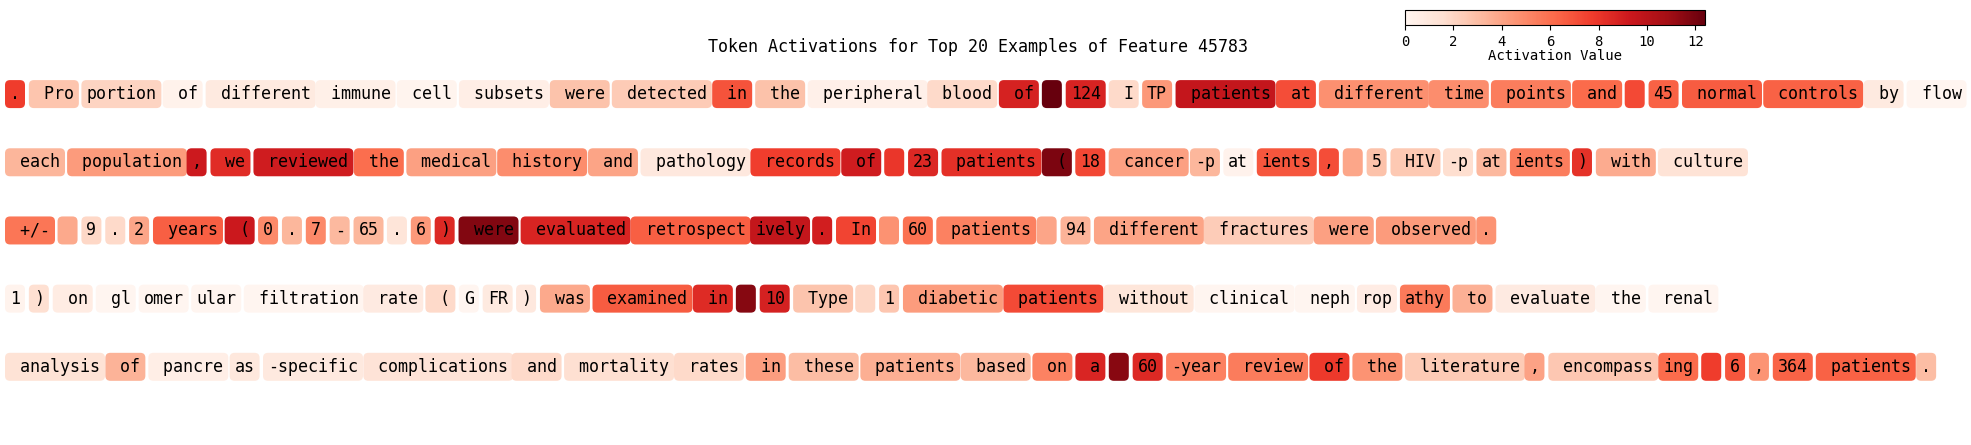

In [177]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import numpy as np

# Use only top20examples from the first code
# Example: top20examples = [("token_list", [activations])]

# Plotting top 20 examples
fig, ax = plt.subplots(figsize=(15, len(top20examples)))  # Adjust height dynamically
plt.title(f"Token Activations for Top 20 Examples of Feature {feat_idx}")

max_val = np.max(top20examples[0][1])
min_val = 0.0

for example_idx, (tokens, activations) in enumerate(top20examples):
    # Normalize activations for color mapping
    norm = Normalize(vmin=min_val, vmax=max_val)
    cmap = cm.Reds  # Use a red colormap

    x_pos = 0.0  # Initialize horizontal position for tokens
    renderer = fig.canvas.get_renderer()  # Renderer for accurate text measurements

    for token, activation in zip(tokens, activations):
        # Map activation value to a color
        color = cmap(norm(activation))

        # Add the token to the plot with a colored background
        text_obj = ax.text(
            x_pos, -example_idx, token,
            fontsize=12, color="black", ha="left", va="center",
            bbox=dict(facecolor=color, edgecolor="none", boxstyle="round,pad=0.3")
        )

        # Use the text object's bounding box to calculate its width
        text_bbox = text_obj.get_window_extent(renderer=renderer)
        text_width = text_bbox.width / fig.dpi  # Convert from pixels to inches
        text_width /= 11.5  # Normalize to reduce excessive spacing

        # Update x-position for the next token, with a small gap
        x_pos += text_width + 0.013  # Add a small gap between tokens

# Add a horizontal colorbar at the top right
cbar_ax = fig.add_axes([0.98, 0.92, 0.2, 0.03])  # [left, bottom, width, height]
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Activation Value", labelpad=0)

# Adjust plot aesthetics
ax.axis('off')
ax.set_xlim(0, x_pos)  # Set x-limits to prevent overflow
ax.set_ylim(-len(top20examples), 0.5)
fig.subplots_adjust(top=0.85, bottom=0.1, left=0.05, right=1.34)

# save png
# plt.savefig("top20examples.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


#### Bottom activations

### Influence LLM

In [5]:
# Required libraries
import os
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config).to(device)

# Load the sparse autoencoder model and weights
input_dim = 3072  
hidden_dim = 2 ** 16 # 65536
model_sae = SparseAutoencoder(input_dim, hidden_dim)
# model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
checkpoint = torch.load("models/checkpoint")
model_sae.load_state_dict(checkpoint['state_dict'])
model_sae.eval()


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:796: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You shouldn't move a model that is dispatched using accelerate hooks.
/tmp/ipykernel_198744/1425182827.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torc

SparseAutoencoder(
  (encoder): Linear(in_features=3072, out_features=65536, bias=True)
  (decoder): Linear(in_features=65536, out_features=3072, bias=True)
)

In [2]:
# Generate artificial latent vector, pass through SAE decoder, and boost it

# Boosted activations setup
feat_idx = 45783
artificial_latent_vector = np.zeros(hidden_dim)
artificial_latent_vector[feat_idx] = 1
multiplier = 40  # Scale the influence
# sent_begin = "Q: Who are you? A:"
# sent_begin = "I am a"
sent_begin = "I am a"
N = 35  # Number of tokens to generate

# if not 0 print
if multiplier != 0:
    print(f"{multiplier} boost on feature {feat_idx}")
else:
    print("No boost")

# Decode to get activations
with torch.no_grad():
    artificial_latent_vector_tensor = torch.tensor(artificial_latent_vector, dtype=torch.float32).unsqueeze(0)
    reconstructed_activations = model_sae.decoder(artificial_latent_vector_tensor)
    boosted_activations = reconstructed_activations.to(torch.float16) * multiplier

# Hook function to add boosted activations to all tokens
def influence_hook(module, input, output):
    if isinstance(output, tuple):  # Handle tuple output
        boosted_output = output[0] + boosted_activations.to(device)
        return (boosted_output,) + output[1:]
    else:
        return output + boosted_activations.to(device)

# # Hook function to add boosted activations to the last token only
# def influence_hook(module, input, output):
#     if isinstance(output, tuple):
#         boosted_output = output[0].clone()
#         boosted_output[:, -1, :] += boosted_activations.to(device)  # Add only to the last token
#         return (boosted_output,) + output[1:]
#     else:
#         boosted_output = output.clone()
#         boosted_output[:, -1, :] += boosted_activations.to(device)
#         return boosted_output

layer_index = 15  # Target layer for injection

try:
    # Register the hook
    hook_handle = model.model.layers[layer_index].register_forward_hook(influence_hook)

    # Text generation loop
    inputs = tokenizer(sent_begin, return_tensors="pt", add_special_tokens=False).to(device)
    input_ids = inputs["input_ids"]

    generated_ids = input_ids.clone()

    for _ in range(N):
        with torch.no_grad():
            outputs = model(input_ids=generated_ids)

            # Maximum likelihood sampling
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(0) 

            # # Extract logits for the last token
            # logits = outputs.logits[:, -1, :]  # Shape: (batch_size, vocab_size)
            
            # # Top-k sampling
            # topk_logits, topk_indices = torch.topk(logits, k=2, dim=-1)  # Top-k logits and their indices
            # probs = torch.nn.functional.softmax(topk_logits, dim=-1)  # Convert to probabilities
            # next_token_id = torch.multinomial(probs, num_samples=1)  # Sample a token
            
            # # Map back to original token indices
            # next_token_id = topk_indices.gather(dim=-1, index=next_token_id)
            
            # Stop generation if EOS or padding token is predicted
            if next_token_id.item() == tokenizer.eos_token_id:
                break
            
            # Append the predicted token ID
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

    # Decode the generated sequence
    generated_text = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
finally:
    # Remove the hook to prevent side effects
    hook_handle.remove()

print(f"Generated text with influence: '{generated_text}'")


30 boost on feature 45783
Generated text with influence: 'I am a 20 year old female who has been diagnosed with a rare disease called SLE (systemic lupus erythemotic) and have been diagnosed with 3 cases of pulmonary'



In [255]:
# zero boost:
print("Generated text without influence: 'I am a little confused about the meaning of the word 'sociology' in the title of this book. I have read the book and I am not sure what the word 's")
# 30 boost on feature 45783:
print("Generated text with influence: 'I am a 20 year old female who has been diagnosed with a rare disease called SLE (systemic lupus erythemotic) and have been diagnosed with 3 cases of pulmonary'")
# 30 boost on feature 54818
print("Generated text with influence: 'I am a 20 year old female with a history of chronic sinusitis. I have had sinusitis for 10 years. I have had sinusitis for 10 years. I have'")
# 30 boost on feature 57957
print("Generated text with influence: 'I am a 2nd year student and I have been diagnosed with a brain tumor. I have been diagnosed with a brain tumor. I have been diagnosed with a brain tumor. I have'")




Generated text without influence: 'I am a little confused about the meaning of the word 'sociology' in the title of this book. I have read the book and I am not sure what the word 's
Generated text with influence: 'I am a 20 year old female who has been diagnosed with a rare disease called SLE (systemic lupus erythemotic) and have been diagnosed with 3 cases of pulmonary'
Generated text with influence: 'I am a 20 year old female with a history of chronic sinusitis. I have had sinusitis for 10 years. I have had sinusitis for 10 years. I have'


### Feature similarity and UMAP (plus feature splitting)


In [2]:
import torch
import heapq  # For maintaining top-k elements
import glob

def top_k_similar_features_global(latent_vector_files, feature_index, k=25):
    # Dictionary to accumulate global similarity scores for each feature
    global_similarities = {}

    # Process each chunk
    for latent_file in latent_vector_files:
        loaded_vectors = torch.load(latent_file)[:,:-3]  # Load current chunk

        # Get the column corresponding to the target feature index
        target_feature = loaded_vectors[:, feature_index]

        # Compute similarity with all other features (columns)
        similarities = torch.nn.functional.cosine_similarity(
            target_feature.unsqueeze(0),  # Make it 2D for broadcasting
            loaded_vectors.T,  # Transpose for feature-wise comparison
            dim=1
        )

        # Accumulate similarity scores globally
        for i, similarity in enumerate(similarities):
            if i not in global_similarities:
                global_similarities[i] = 0.0
            global_similarities[i] += similarity.item()

    # Identify the top-k features globally
    top_k_features = heapq.nlargest(k, global_similarities.items(), key=lambda x: x[1])

    return top_k_features  # Returns a list of (feature_index, aggregated_similarity) tuples

# Example usage
latent_vector_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))
feature_index = 12219  # Index of the feature to compare
top_k = 100
top_k_features = top_k_similar_features_global(latent_vector_files, feature_index, k=top_k)

# Display results
for idx, agg_similarity in top_k_features[:25]:
    print(f"Feature {idx} has aggregated similarity {agg_similarity:.4f}")


/tmp/ipykernel_5332/1154084610.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vectors = torch.load(latent_file)[:,:-3]  # Load current chunk


Feature 12219 has aggregated similarity 95.0000
Feature 33348 has aggregated similarity 24.2779
Feature 56081 has aggregated similarity 21.4517
Feature 48378 has aggregated similarity 21.2307
Feature 49406 has aggregated similarity 20.9326
Feature 60636 has aggregated similarity 20.8537
Feature 50974 has aggregated similarity 20.7454
Feature 17505 has aggregated similarity 20.6152
Feature 1594 has aggregated similarity 20.4244
Feature 57862 has aggregated similarity 20.2067
Feature 7914 has aggregated similarity 20.1541
Feature 40773 has aggregated similarity 20.1271
Feature 60113 has aggregated similarity 20.1265
Feature 36097 has aggregated similarity 20.1095
Feature 61739 has aggregated similarity 20.0652
Feature 40515 has aggregated similarity 19.9952
Feature 23242 has aggregated similarity 19.8270
Feature 19980 has aggregated similarity 19.8028
Feature 102 has aggregated similarity 19.7638
Feature 44440 has aggregated similarity 19.7061
Feature 31970 has aggregated similarity 19.3

In [5]:
feat_ixs = [i for i, _ in top_k_features]
feat_ixs

[12219,
 33348,
 56081,
 48378,
 49406,
 60636,
 50974,
 17505,
 1594,
 57862,
 7914,
 40773,
 60113,
 36097,
 61739,
 40515,
 23242,
 19980,
 102,
 44440,
 31970,
 53915,
 50355,
 42403,
 41106,
 2812,
 36770,
 35616,
 27833,
 35098,
 48360,
 11369,
 35009,
 40721,
 33551,
 10336,
 27528,
 18094,
 64382,
 14609,
 59227,
 33009,
 22958,
 21864,
 26801,
 60492,
 33656,
 48507,
 12114,
 8488,
 1032,
 25570,
 5518,
 41465,
 58452,
 11799,
 53527,
 26536,
 48007,
 22649,
 12428,
 43027,
 49251,
 44218,
 8752,
 30040,
 63443,
 285,
 39139,
 36785,
 15941,
 23520,
 14523,
 21303,
 45157,
 55401,
 30525,
 53495,
 53931,
 4823,
 55882,
 64993,
 43260,
 15610,
 54948,
 40124,
 56572,
 26693,
 44618,
 12067,
 41415,
 24785,
 5712,
 23393,
 54304,
 10463,
 13651,
 31034,
 32965,
 55900]

In [12]:
# umap-learn
# pip install umap-learn
import umap
import matplotlib.pyplot as plt
import torch
import numpy as np
import glob

# Load first N batches
N = 100  # Number of batches to load
batch_files = sorted(glob.glob("sparse_latent_vectors/latent_vectors_batch_*.pt"))[:N]
feat_100ixs = [12219, 33348, 56081, 48378, 49406, 60636, 50974, 17505, 1594, 57862, 7914, 40773, 60113,
 36097, 61739, 40515, 23242, 19980, 102, 44440, 31970, 53915, 50355, 42403, 41106, 2812, 36770, 35616,
 27833, 35098, 48360, 11369, 35009, 40721, 33551, 10336, 27528, 18094, 64382, 14609, 59227, 33009,
 22958, 21864, 26801, 60492, 33656, 48507, 12114, 8488, 1032, 25570, 5518, 41465, 58452, 11799,
 53527, 26536, 48007, 22649, 12428, 43027, 49251, 44218, 8752, 30040, 63443, 285, 39139, 36785,
 15941, 23520, 14523, 21303, 45157, 55401, 30525, 53495, 53931, 4823, 55882, 64993, 43260,
 15610, 54948, 40124, 56572, 26693, 44618, 12067, 41415, 24785, 5712, 23393, 54304, 10463,
 13651, 31034, 32965, 55900]

# Load and concatenate batches
latent_vectors = []
for batch_file in batch_files:
    batch_vectors = torch.load(batch_file).cpu().numpy()
    batch_vectors = batch_vectors[:, feat_100ixs]
    latent_vectors.append(batch_vectors)
latent_vectors = np.concatenate(latent_vectors, axis=0)

# Remove last 3 columns (sent_idx, tok_idx, token)
latent_vectors = latent_vectors[:, :-3]

print(f"Loaded {len(batch_files)} batches, total shape: {latent_vectors.shape}")


# Define feature names (example: replace with real names if available)
feature_names = {
    33656: 'Nature and geography',
    50974: 'Detailed descriptions',
    23393: 'Public infrastructure',
    33348: 'Institution names',
    12219: 'Corporate entities',
    36770: 'Professional societal analysis',
    26536: 'Product advertising tone',
    45157: 'Institutional titles',
    56081: 'Major tech brands',
    48378: 'Notable names',
    49406: 'Technical descriptions',
    60636: 'Family references',
    17505: 'Formal writing style',
    1594: 'Names in legal contexts',
    57862: 'Regulatory terms',
    7914: 'Geographic mentions',
    40773: 'Formal suffix terms',
    60113: 'Corporate references'
}
default_name = "Feature"  # For unnamed features

# UMAP dimensionality reduction
umap_embedder = umap.UMAP(n_components=2, metric='cosine')
latent_vectors_2d = umap_embedder.fit_transform(latent_vectors.T)


/tmp/ipykernel_5332/1983930542.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_vectors = torch.load(batch_file).cpu().numpy()


Loaded 95 batches, total shape: (389120, 97)


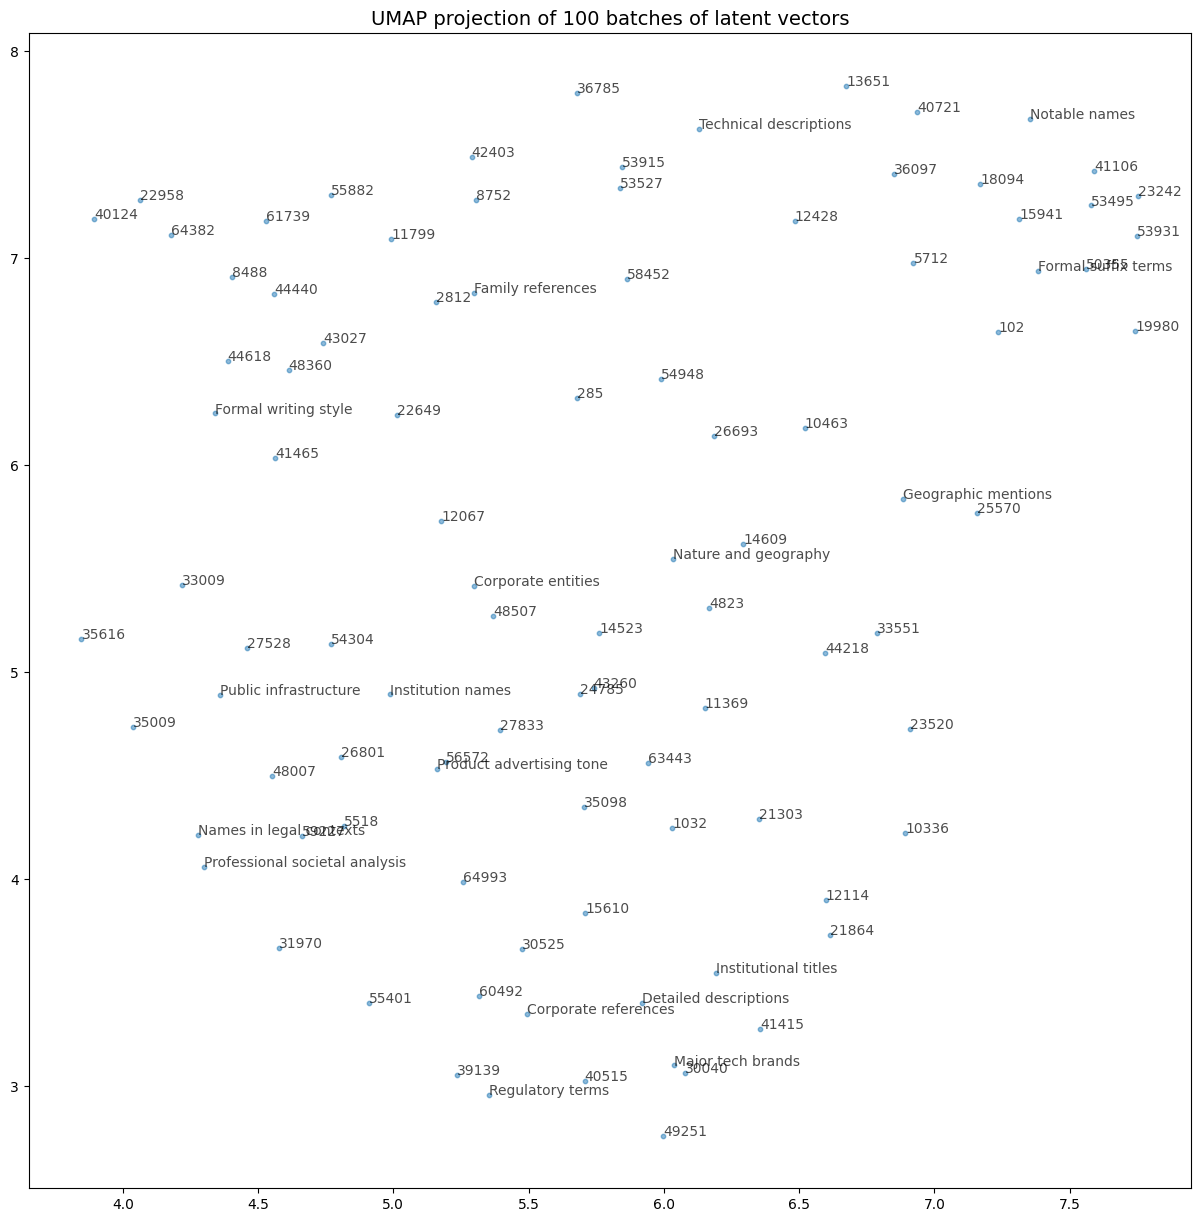

In [13]:

# Plot
plt.figure(figsize=(15, 15))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], s=10, alpha=0.5)

# Add labels
for i, (x, y) in enumerate(latent_vectors_2d):
    feature_idx = feat_100ixs[i]
    label = feature_names.get(feature_idx, f"{feature_idx}") # f"{default_name} {feature_idx}"
    plt.text(x, y, label, fontsize=10, alpha=0.7, rotation=0)

plt.title(f'UMAP projection of {N} batches of latent vectors', fontsize=14)
plt.show()

#### Feature splitting - UMAP
Larger SAE models have more features, thus more fine-grained categories.
(Find the same feature in models of different sizes, and anchor that feature to the same point in the UMAP space, see how the other features are distributed around it)

### Feature specificity

From 0-3, how well does feature name describe the context sentences?

### Feature completness

How many topics does the model cover? (i.e. One feature for each borough in London?)

## Feature search

### Single prompt search

In [6]:
activation_cache = []
def save_activations_hook(module, input, output):
    # input is a tuple; input[0] is the tensor we need
    activation_cache.append(input[0].cpu().detach().numpy())

# Register hook on the 16th layer
layer_index = 15  # Zero-based index; 15 corresponds to the 16th layer
hook_handle = model.model.layers[layer_index].register_forward_hook(save_activations_hook) 

In [7]:
prompt = "in San Francisco, the Golden Gate Bridge was protected at all times by a"

# Tokenize sentence
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    # truncation=True,
    # max_length=512,
    # padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, 1, seq_len, 3072)
activations = activations.squeeze()  # Remove first two dimensions
activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor with float16 dtype

# Get latent vector for sentence
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy() # (seq_len, 1M)

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across sentence
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 5
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")



Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Activations shape: (1, 1, 16, 3072)
Top 5 features and their activation values:
Feature 58517: 0.8039
Feature 8306: 0.0409
Feature 26908: 0.0371
Feature 50988: 0.0336
Feature 53475: 0.0117


Multiple prompts:
 * tokenize to fixed length
 * reshape activations to (num_sent*seq_len, 3072)
 * get attention mask and remove padding tokens
 


In [1]:
# prompts = [
#     "in San Francisco, the Golden Gate Bridge was protected at all times by a",
#     "the Golden Gate Bridge is so beautiful during the sunset", 
#     "Golden Gate Bridge wind resistance barriers creates eerie sound"
# ]

prompts = [
    "program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into 2 groups. Thirteen subjects",
    "the effect of a traditional dance training program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into",
    "been examined comprehensively. Peritoneal lavage was performed in 351 patients before curative resection of a gastric carcinoma between 1987 and"
]
# target feature index = 54818

# # Paraphrased sentences
# prompts = [
#     "A program focused on improving aerobic capacity and muscle strength in adults with hearing loss was conducted. Twenty-three participants with hearing loss were divided into two groups, with thirteen individuals in one",
#     "The impact of traditional dance training on aerobic capacity and muscle strength in adults with hearing loss was studied. Twenty-three individuals with hearing loss were split into two groups.",
#     "A comprehensive examination was conducted involving peritoneal lavage in 351 patients prior to curative gastric carcinoma resection between 1987 and"
# ]

# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=35, # can equal to the length (in tokens) of the longest sentence
                   # limit suggested due to VRAM constraints
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()

# Apply min-max normalization to latent vectors
latent_vector_normalized = (latent_vector - np.min(latent_vector, axis=0)) / (np.max(latent_vector, axis=0) - np.min(latent_vector, axis=0) + 1e-8)

# Get mean activation for each feature across tokens
mean_activation = np.mean(latent_vector_normalized, axis=0)

# Get top k features and their mean activation values
top_k = 10
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print("Top 10 features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")



Activations shape: (1, 5, 35, 3072)
Top 10 features and their mean activation values:
Feature 32026: 0.2996
Feature 57660: 0.2853
Feature 45783: 0.2745
Feature 41517: 0.2728
Feature 64668: 0.2667
Feature 29073: 0.2629
Feature 14701: 0.2558
Feature 6527: 0.2511 
Feature 49447: 0.2490
Feature 52757: 0.2487



In [69]:
orig_latent_vector = latent_vector.copy()

In [70]:
# replace zeros with -inf in latent_vector
latent_vector[latent_vector == 0] = -np.inf

# Apply row softmax normalization
row_softmax = torch.nn.functional.softmax(torch.tensor(latent_vector), dim=1).numpy()

# Sum over sequence length dimension to get feature importance across all sentences
feature_importance = np.sum(row_softmax, axis=0)

# Get top 5 features and their values
top_k = 15
top_feature_indices = np.argsort(feature_importance)[-top_k:][::-1]
top_feature_values = feature_importance[top_feature_indices]

print("Top 5 features and their activation values:")
for idx, val in zip(top_feature_indices, top_feature_values):
    print(f"Feature {idx}: {val:.4f}")

Top 5 features and their activation values:
Feature 58517: 2.4159
Feature 52875: 0.1474
Feature 8306: 0.1215
Feature 26908: 0.1121
Feature 50988: 0.1027
Feature 53475: 0.0360
Feature 56881: 0.0337
Feature 15287: 0.0227
Feature 31416: 0.0224
Feature 17187: 0.0215
Feature 4581: 0.0208
Feature 51982: 0.0199
Feature 4766: 0.0194
Feature 45783: 0.0165
Feature 21476: 0.0152


In [71]:
#latent_vector[:10, :10]
for row in latent_vector[:10]:
    # 3 decimal places
    print(np.round(row[58515:58520], 3))



[  -inf   -inf 30.119  4.437  0.834]
[-inf -inf -inf -inf -inf]
[-inf -inf -inf 0.04 -inf]
[0.028  -inf  -inf 0.04   -inf]
[ -inf  -inf  -inf 0.101  -inf]
[-inf -inf -inf -inf -inf]
[ -inf  -inf  -inf 0.338  -inf]
[ -inf  -inf  -inf 0.041 0.041]
[ -inf  -inf  -inf 0.067  -inf]
[ -inf  -inf  -inf 0.145  -inf]


In [72]:
for row in row_softmax[:10]:
    print(np.round(row[58515:58520], 3))

[0.    0.    0.805 0.    0.   ]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


In [73]:

# get max value for each feature
max_values = np.max(latent_vector, axis=0)
# sort and take top 10 - get indices
top_k = 10
top_k_indices = np.argsort(max_values)[-top_k:][::-1]
top_k_values = max_values[top_k_indices]
print("Top 10 features and their max values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

Top 10 features and their max values:
Feature 58517: 30.1187
Feature 8306: 27.1241
Feature 26908: 27.0284
Feature 50988: 26.9250
Feature 53475: 25.8634
Feature 56881: 25.7940
Feature 15287: 25.4184
Feature 31416: 25.2927
Feature 17187: 25.2357
Feature 4766: 25.1272


In [74]:
latent_vector = orig_latent_vector.copy()

In [75]:
latent_vector_normalized = (latent_vector - np.min(latent_vector, axis=0)) / (np.max(latent_vector, axis=0) - np.min(latent_vector, axis=0) + 1e-8)
print(latent_vector[:10, 58515:58520])

mean_activation = np.mean(latent_vector_normalized, axis=0)
top_k = 10
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]
print("Top 10 features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

# norm + row softmax
latent_softmax = np.exp(latent_vector_normalized) / np.sum(np.exp(latent_vector_normalized), axis=1, keepdims=True)
latent_soft_sum = np.sum(latent_softmax, axis=0)
top_k = 10
top_k_indices = np.argsort(latent_soft_sum)[-top_k:][::-1]
top_k_values = latent_soft_sum[top_k_indices]
print("Top 10 features and their sum of softmax values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


feature_variance = np.var(latent_vector_normalized, axis=0)
# low_variance_features = np.where(feature_variance < 0.05)[0]
# top_k with lowest variance
top_k = 10
top_k_indices = np.argsort(feature_variance)[:top_k]
top_k_values = feature_variance[top_k_indices]
print("Top 10 features and their variance values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

# colum count non zero, top 10
non_zero_counts = np.count_nonzero(latent_vector, axis=0)
top_k = 10
top_k_indices = np.argsort(non_zero_counts)[-top_k:][::-1]
top_k_values = non_zero_counts[top_k_indices]
print("Top 10 features and their non-zero counts:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val}")

[[0.0000000e+00 0.0000000e+00 3.0118706e+01 4.4373045e+00 8.3437085e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0140603e-02 0.0000000e+00]
 [2.7645580e-02 0.0000000e+00 0.0000000e+00 4.0321290e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0098342e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 3.3847067e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 4.1343972e-02 4.0809222e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 6.6959187e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4525917e-01 0.0000000e+00]]
Top 10 features and their mean activation values:
Feature 45783: 0.2960
Feature 12060: 0.2873
Feature 14742: 0.2796
Feature 46445: 0.2696
Feature 64668: 0.2673
Feature 13487: 0.2660
Feature 27963: 0.2620
Feature 14701: 0.2606
Feature 17260: 0.2576
Feature 17423: 0.2556

In [76]:
v_mean = np.mean(feature_variance)
print(f"Mean variance: {v_mean:.4f}")
# top 10 that are closest to v_mean
top_k = 10
top_k_indices = np.argsort(np.abs(feature_variance - v_mean))[:top_k]
top_k_values = feature_variance[top_k_indices]
print("Top 10 features and their variance values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

Mean variance: 0.0307
Top 10 features and their variance values:
Feature 50470: 0.0307
Feature 43195: 0.0307
Feature 40535: 0.0307
Feature 9257: 0.0307
Feature 24726: 0.0307
Feature 29699: 0.0307
Feature 60785: 0.0307
Feature 12775: 0.0307
Feature 54607: 0.0307
Feature 55586: 0.0307


### Prompt combination

add negative prompts

In [60]:
# Business entities
positive_prompts = [
    "Global manufacturing leader, Stellar Dynamics Corp., announced record-breaking quarterly earnings",
    "Neptune Biotech, Ltd., continues to pioneer advancements in gene therapy",
    "BrightPath Solutions LLC specializes in custom software solutions for medium-sized enterprises",
    "Apex Innovations Inc. unveiled their latest AI-powered diagnostics tool.",
    "Orion Ventures, Inc., secured a $25 million investment for expansion.",
    "Luminary Retail Group reported a 15 percent increase in Q3 revenue.",
    "The Green Earth Foundation launched a global tree-planting initiative.",
    "Vanguard Electronics, Inc., introduces a revolutionary energy storage system.",
    "NovaCraft, Ltd., expands its product line to include eco-friendly materials.",
    "Prime Consulting LLC offers strategic business solutions for startups."
]

# # positive only
# negative_prompts = []

# # talk about random other stuff
# negative_prompts = [
#     "The sun dipped below the horizon, painting the sky in shades of orange and pink",
#     "A soft breeze rustled through the leaves, carrying the scent of freshly cut grass",
#     "The old wooden bridge creaked under the weight of the solitary traveler"
# ]

# # explicitly tells which part of the sentence we are not interested in
# negative_prompts = [
#     "A global leader announced record-breaking quarterly earnings",
#     "Advances in gene therapy continue to shape the future of medicine",
#     "Custom software solutions are becoming increasingly essential for medium-sized enterprises"
# ]

# finetuned negative prompts
negative_prompts = [
    "The genus *Protochrysis* (type species *P. magna*) plays a crucial role in this ecological niche.",
    "North Africa offers a wide range of aesthetic attractions, from urban design to historic landscapes.",
    # "Superior customer service and high-quality products define our company's commitment to excellence.",
    "The framework calculates the terms for \(x^3 - 3x^2 + 2x - 1\) in a single iteration.",
    "One of the most significant discoveries in modern physics was the identification of the Higgs boson.",
    "The average home temperature dropped significantly during the energy-saving pilot program.",
    "Advances in neural technology have enhanced the accuracy of speech-to-text applications.",
    "Model 2023/477 remains one of the most durable in the entire lineup.",
    "# Comment: Initialize variables for the loop control mechanism.",
    "In the formula \(a^2 - b^2 = (a - b)(a + b)\), each term is simplified independently.",
    "The City Hall building now includes a community garden open to all residents.",
    "The app remains available offline for users in areas with limited connectivity.",
    "Please click the 'Submit' button to finalize your registration.",
    # "Thursday's seminar will cover the basics of digital marketing.",
    # "Sentosa Care has been a leading provider in long-term healthcare solutions for decades."
]

# target_feature = 60113
prompts = positive_prompts + negative_prompts


# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=35, # can equal to the length (in tokens) of the longest sentence
                   # limit suggested due to VRAM constraints
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Build index tensor for sentence separation
sent_idx_tensor = torch.tensor([[i] * seq_len for i in range(num_sent)]).flatten()

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]
sent_idx_tensor = sent_idx_tensor[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()


###############################################################################
# 1. Local min-max normalization (pos, neg separately) ->  mean(pos)-mean(neg)
############################################################################### (decent)

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_vector[pos_ix]
# Apply min-max normalization to latent vectors
latent_vector_normalized = (pos_latent - np.min(pos_latent, axis=0)) / (np.max(pos_latent, axis=0) - np.min(pos_latent, axis=0) + 1e-8)
# Get mean activation for each feature across tokens
mean_activation = np.mean(latent_vector_normalized, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_vector[neg_ix]
    # # get indexes in neg_latent of those columns with all non-zero values
    # neg_non_zero = np.where(np.all(neg_latent, axis=0))[0]
    # # Remove with negative prompts 
    # mean_activation[neg_non_zero] = 0
    # Apply min-max normalization to latent vectors
    neg_latent_normalized = (neg_latent - np.min(neg_latent, axis=0)) / (np.max(neg_latent, axis=0) - np.min(neg_latent, axis=0) + 1e-8)
    # Get mean activation for each feature across tokens
    neg_mean_activation = np.mean(neg_latent_normalized, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


Activations shape: (1, 22, 35, 3072)
Top 15 features and their mean activation values:
Feature 29043: 0.2200
Feature 24541: 0.2092
Feature 24855: 0.1961
Feature 7916: 0.1891
Feature 12219: 0.1882
Feature 34760: 0.1866
Feature 52170: 0.1791
Feature 15742: 0.1770
Feature 52152: 0.1754
Feature 11470: 0.1751
Feature 63732: 0.1718
Feature 16324: 0.1683
Feature 48168: 0.1630
Feature 1648: 0.1623
Feature 54205: 0.1620


In [61]:
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])

(array([148]),)
0.114323944


In [56]:
###############################################################################
# 1.2. Local min-max normalization (all together) ->  mean(pos)-mean(neg)
############################################################################### (decent)

latent_vector_norm = (latent_vector - np.min(latent_vector, axis=0)) / (np.max(latent_vector, axis=0) - np.min(latent_vector, axis=0) + 1e-8)

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_vector_norm[pos_ix]
# Get mean activation for each feature across tokens
mean_activation = np.mean(pos_latent, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_vector_norm[neg_ix]
    # Get mean activation for each feature across tokens
    neg_mean_activation = np.mean(neg_latent, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

Top 15 features and their mean activation values:
Feature 24855: 0.2330
Feature 24541: 0.2212
Feature 12219: 0.2074
Feature 24511: 0.1926
Feature 13310: 0.1898
Feature 52152: 0.1876
Feature 13955: 0.1826
Feature 1648: 0.1823
Feature 29043: 0.1819
Feature 63947: 0.1715
Feature 15742: 0.1711
Feature 33346: 0.1683
Feature 62735: 0.1674
Feature 23046: 0.1651
Feature 16131: 0.1649


In [59]:
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])

(array([160]),)
0.114323944


global min max normalization

In [7]:
# Business entities
positive_prompts = [
    "Global manufacturing leader, Stellar Dynamics Corp., announced record-breaking quarterly earnings",
    "Neptune Biotech, Ltd., continues to pioneer advancements in gene therapy",
    "BrightPath Solutions LLC specializes in custom software solutions for medium-sized enterprises",
    "Apex Innovations Inc. unveiled their latest AI-powered diagnostics tool.",
    "Orion Ventures, Inc., secured a $25 million investment for expansion.",
    "Luminary Retail Group reported a 15 percent increase in Q3 revenue.",
    "The Green Earth Foundation launched a global tree-planting initiative.",
    "Vanguard Electronics, Inc., introduces a revolutionary energy storage system.",
    "NovaCraft, Ltd., expands its product line to include eco-friendly materials.",
    "Prime Consulting LLC offers strategic business solutions for startups."
]

# # positive only
# negative_prompts = []

# # talk about random other stuff
# negative_prompts = [
#     "The sun dipped below the horizon, painting the sky in shades of orange and pink",
#     "A soft breeze rustled through the leaves, carrying the scent of freshly cut grass",
#     "The old wooden bridge creaked under the weight of the solitary traveler"
# ]

# # explicitly tells which part of the sentence we are not interested in
# negative_prompts = [
#     "A global leader announced record-breaking quarterly earnings",
#     "Advances in gene therapy continue to shape the future of medicine",
#     "Custom software solutions are becoming increasingly essential for medium-sized enterprises"
# ]

# finetuned negative prompts
negative_prompts = [
    "The genus *Protochrysis* (type species *P. magna*) plays a crucial role in this ecological niche.",
    "North Africa offers a wide range of aesthetic attractions, from urban design to historic landscapes.",
    # "Superior customer service and high-quality products define our company's commitment to excellence.",
    "The framework calculates the terms for \(x^3 - 3x^2 + 2x - 1\) in a single iteration.",
    "One of the most significant discoveries in modern physics was the identification of the Higgs boson.",
    "The average home temperature dropped significantly during the energy-saving pilot program.",
    "Advances in neural technology have enhanced the accuracy of speech-to-text applications.",
    "Model 2023/477 remains one of the most durable in the entire lineup.",
    "# Comment: Initialize variables for the loop control mechanism.",
    "In the formula \(a^2 - b^2 = (a - b)(a + b)\), each term is simplified independently.",
    "The City Hall building now includes a community garden open to all residents.",
    "The app remains available offline for users in areas with limited connectivity.",
    "Please click the 'Submit' button to finalize your registration.",
    # "Thursday's seminar will cover the basics of digital marketing.",
    # "Sentosa Care has been a leading provider in long-term healthcare solutions for decades."
]

# target_feature = 60113
prompts = positive_prompts + negative_prompts


# Tokenize sentences
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    max_length=35, # can equal to the length (in tokens) of the longest sentence
                   # limit suggested due to VRAM constraints
    padding="max_length",
).to(device)

activation_cache = []
# Forward pass
with torch.no_grad():
    model(**inputs)

activations = np.array(activation_cache)
print(f"Activations shape: {activations.shape}") # (1, num_sent, seq_len, 3072)

# Reshape activations to (num_sent*seq_len, 3072)
activations = activations.squeeze(0)  # Remove batch dimension
num_sent, seq_len, hidden_dim = activations.shape
activations = activations.reshape(-1, hidden_dim)

# Build index tensor for sentence separation
sent_idx_tensor = torch.tensor([[i] * seq_len for i in range(num_sent)]).flatten()

# Get attention mask and remove padding tokens
attention_mask = inputs['attention_mask'].view(-1).cpu().numpy()
activations = activations[attention_mask == 1]
sent_idx_tensor = sent_idx_tensor[attention_mask == 1]

activations = torch.tensor(activations, dtype=torch.float32)  # Convert to torch tensor

# Get latent vectors for sentences
with torch.no_grad():
    _, encoded = model_sae(activations)
    latent_vector = encoded.cpu().numpy()


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Activations shape: (1, 22, 35, 3072)


In [52]:

###############################################################################
# 2. Global min-max normalization ->  mean(pos)-mean(neg)
############################################################################### (bad - due to outliers)

min_vals, max_vals = torch.load('sparse_latent_vectors/min_max_values.pt') # min, max for each column/feature
# from tensor cuda to numpy
min_vals = min_vals.cpu().numpy()
max_vals = max_vals.cpu().numpy()
latent_norm = (latent_vector - min_vals) / (max_vals - min_vals + 1e-8)

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_norm[pos_ix]
# Get mean activation for each feature across tokens
mean_activation = np.mean(pos_latent, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_norm[neg_ix]
    neg_mean_activation = np.mean(neg_latent, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


Top 15 features and their mean activation values:
Feature 56262: 0.1633
Feature 61163: 0.1507
Feature 15007: 0.1474
Feature 27515: 0.1457
Feature 27710: 0.1404
Feature 50122: 0.1396
Feature 21476: 0.1356
Feature 34673: 0.1322
Feature 44345: 0.1320
Feature 19754: 0.1320
Feature 64470: 0.1316
Feature 12468: 0.1316
Feature 61374: 0.1298
Feature 47231: 0.1287
Feature 49358: 0.1276


/tmp/ipykernel_198744/1855611561.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  min_vals, max_vals = torch.load('sparse_latent_vectors/min_max_values.pt') # min, max fo

In [55]:
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])

(array([9787]),)
0.03440174


In [47]:

###############################################################################
# 3. Global min-max 99th percentile normalization ->  mean(pos)-mean(neg)
#                removes outliers
############################################################################### 

min_vals, max_vals = torch.load('sparse_latent_vectors/min_max_percentile.pt') 
# from tensor cuda to numpy
min_vals = min_vals.cpu().numpy()
max_vals = max_vals.cpu().numpy()
# clip
latent_norm = np.clip(latent_vector, min_vals, max_vals)
# norm
latent_norm = (latent_vector - min_vals) / (max_vals - min_vals + 1e-8)

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_norm[pos_ix]
# Get mean activation for each feature across tokens
mean_activation = np.mean(pos_latent, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_norm[neg_ix]
    neg_mean_activation = np.mean(neg_latent, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


Top 15 features and their mean activation values:
Feature 21382: 4.1950
Feature 56262: 1.0209
Feature 23451: 0.9857
Feature 44105: 0.7802
Feature 40923: 0.7409
Feature 61163: 0.6852
Feature 14622: 0.6314
Feature 12468: 0.6265
Feature 45147: 0.6244
Feature 21832: 0.6121
Feature 26099: 0.6025
Feature 17504: 0.5936
Feature 37763: 0.5786
Feature 15007: 0.5670
Feature 54872: 0.5197


/tmp/ipykernel_198744/2224949433.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  min_vals, max_vals = torch.load('sparse_latent_vectors/min_max_percentile.pt')


In [51]:
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])

(array([4665]),)
0.16381782


In [19]:
# Feature 21382: 4.1950
# Feature 56262: 1.0209
# Feature 23451: 0.9857
# Feature 44105: 0.7802
# Feature 40923: 0.7409
# Feature 61163: 0.6852
# Feature 14622: 0.6314
# Feature 12468: 0.6265
# Feature 45147: 0.6244
# Feature 21832: 0.6121
# Feature 26099: 0.6025
# Feature 17504: 0.5936
# Feature 37763: 0.5786
# Feature 15007: 0.5670
# Feature 54872: 0.5197
max_vals[21382], max_vals[56262], max_vals[23451], max_vals[44105], max_vals[40923], max_vals[61163], max_vals[14622], max_vals[12468], max_vals[45147], max_vals[21832], max_vals[26099], max_vals[17504], max_vals[37763], max_vals[15007], max_vals[54872]

(0.023428988,
 0.22489017,
 0.09634826,
 0.1803687,
 0.08019312,
 0.32070342,
 0.2009592,
 0.34152442,
 0.3193529,
 0.23484354,
 0.28648207,
 0.3073111,
 0.3227511,
 0.4006542,
 0.15736315)

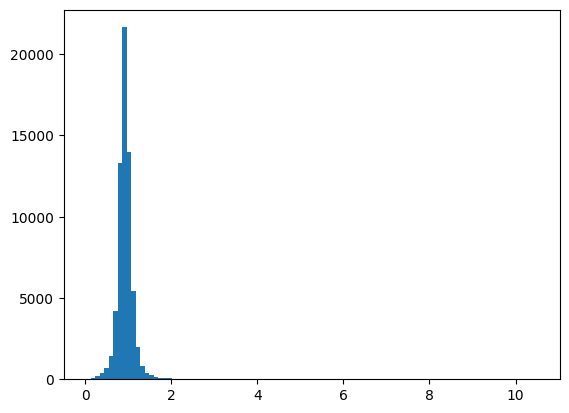

In [24]:
# plot max_vals histogram
import matplotlib.pyplot as plt
plt.hist(max_vals, bins=100)
plt.show()


In [21]:
# max_vals smallest 10
top_k = 20
top_k_indices = np.argsort(max_vals)[:top_k]
top_k_values = max_vals[top_k_indices]
print("Top 10 features and their max values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")

Top 10 features and their max values:
Feature 21382: 0.0234
Feature 56853: 0.0504
Feature 58974: 0.0698
Feature 40923: 0.0802
Feature 32527: 0.0828
Feature 10634: 0.0832
Feature 14325: 0.0962
Feature 23451: 0.0963
Feature 5978: 0.0976
Feature 64719: 0.1033
Feature 14999: 0.1055
Feature 8707: 0.1064
Feature 48029: 0.1065
Feature 57960: 0.1078
Feature 47576: 0.1095
Feature 47522: 0.1098
Feature 51094: 0.1112
Feature 35773: 0.1125
Feature 32811: 0.1133
Feature 6599: 0.1164


In [43]:

###############################################################################
# 4. Global standardization (mean and std norm) ->  mean(pos)-mean(neg)
#       (also called z-score normalization)
############################################################################### 

mean_vals, std_vals = torch.load('sparse_latent_vectors/mean_std_values.pt')
# from tensor cuda to numpy
mean_vals = mean_vals.cpu().numpy()
std_vals = std_vals.cpu().numpy()
latent_norm = (latent_vector - mean_vals) / (std_vals + 1e-8)

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_norm[pos_ix]
# Get mean activation for each feature across tokens
mean_activation = np.mean(pos_latent, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_norm[neg_ix]
    neg_mean_activation = np.mean(neg_latent, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


Top 15 features and their mean activation values:
Feature 56262: 4.8658
Feature 21382: 4.2616
Feature 61163: 3.6018
Feature 12468: 3.3949
Feature 44105: 3.3643
Feature 45147: 3.3344
Feature 17504: 3.2238
Feature 26099: 3.1436
Feature 15007: 3.0800
Feature 21832: 3.0277
Feature 23451: 2.9933
Feature 37763: 2.9922
Feature 14622: 2.9617
Feature 21900: 2.6717
Feature 30301: 2.6485


/tmp/ipykernel_198744/4158350860.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_vals, std_vals = torch.load('sparse_latent_vectors/mean_std_values.pt')


In [46]:
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])

(array([4708]),)
0.7849686


In [40]:

###############################################################################
# 4. Cohen's d :  mean(pos)-mean(neg) / pooled_std
############################################################################### 

# Positive prompts
pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_vector[pos_ix]
# Get mean activation for each feature across tokens
mean_activation = np.mean(pos_latent, axis=0)

# Negative prompts
if len(negative_prompts) > 0:
    neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
    neg_latent = latent_vector[neg_ix]
    neg_mean_activation = np.mean(neg_latent, axis=0)
    # Subtract negative mean activation
    mean_activation -= neg_mean_activation

# Divide by pooled standard deviation 
pooled_std = np.sqrt((np.var(pos_latent, axis=0) + np.var(neg_latent, axis=0)) / 2)
# more accurate:
# pooled_var = ((n_pos - 1)*var_pos + (n_neg - 1)*var_neg) / (n_pos + n_neg - 2)
# pooled_std = np.sqrt(pooled_var)
mean_activation /= pooled_std

# Get top k features and their mean activation values
top_k = 15
top_k_indices = np.argsort(mean_activation)[-top_k:][::-1]
top_k_values = mean_activation[top_k_indices]

print(f"Top {top_k} features and their mean activation values:")
for idx, val in zip(top_k_indices, top_k_values):
    print(f"Feature {idx}: {val:.4f}")


Top 15 features and their mean activation values:
Feature 24541: 1.1260
Feature 24855: 1.0981
Feature 13310: 1.0955
Feature 12219: 1.0793
Feature 13955: 1.0715
Feature 24511: 1.0165
Feature 29043: 0.9806
Feature 16131: 0.9694
Feature 2824: 0.9486
Feature 62735: 0.9453
Feature 52152: 0.9327
Feature 25123: 0.9162
Feature 39565: 0.9124
Feature 24690: 0.8947
Feature 1648: 0.8909


In [42]:
# find 60113
print( np.where(np.argsort(mean_activation)[::-1] == 60113) )
print(mean_activation[60113])


(array([882]),)
0.45314968


In [33]:
###############################################################################
# 5. Rank-based method
############################################################################### 

pos_ix = np.where(sent_idx_tensor < len(positive_prompts))[0]
pos_latent = latent_vector[pos_ix]
neg_ix = np.where(sent_idx_tensor >= len(positive_prompts))[0]
neg_latent = latent_vector[neg_ix]

# 1. Choose how large the "top slice" is. 
#    For example, top_frac = 0.05 means top 5% of features for each token.
#    Or use top_k = 100 to pick top 100 features per token.
top_frac = 0.05 # at 65k features, this is 3250 features
num_features = pos_latent.shape[1]  # same as neg_latent.shape[1]

top_k = int(num_features * top_frac)  # number of features to pick per token
top_k = max(top_k, 1)                # ensure at least 1

# 2. Count how often each feature appears in that top slice for positive vs. negative.

pos_count = np.zeros(num_features, dtype=np.int64)
for row in pos_latent:
    # row shape: (num_features,)
    # get indices of top_k features in that row
    # argsort returns ascending, so we take last top_k
    top_indices = np.argpartition(row, -top_k)[-top_k:]
    # increment counts
    pos_count[top_indices] += 1

neg_count = np.zeros(num_features, dtype=np.int64)
for row in neg_latent:
    top_indices = np.argpartition(row, -top_k)[-top_k:]
    neg_count[top_indices] += 1

# 3. Convert counts to frequencies (how often a feature is in top_k%).
pos_freq = pos_count / pos_latent.shape[0]
neg_freq = neg_count / neg_latent.shape[0]

# 4. Score = difference or ratio, e.g. difference:
score = pos_freq - neg_freq

# 5. Sort by score descending
sorted_features = np.argsort(score)[::-1]
topN = 15
for i in range(topN):
    f_idx = sorted_features[i]
    print(f"Feature {f_idx} => pos_freq={pos_freq[f_idx]:.4f}, neg_freq={neg_freq[f_idx]:.4f}, score={score[f_idx]:.4f}")


Feature 13955 => pos_freq=0.6233, neg_freq=0.1644, score=0.4588
Feature 36770 => pos_freq=0.5548, neg_freq=0.1067, score=0.4481
Feature 26536 => pos_freq=0.6027, neg_freq=0.1644, score=0.4383
Feature 13310 => pos_freq=0.7945, neg_freq=0.3689, score=0.4256
Feature 42874 => pos_freq=0.5137, neg_freq=0.0978, score=0.4159
Feature 11964 => pos_freq=0.4932, neg_freq=0.0933, score=0.3998
Feature 46196 => pos_freq=0.4452, neg_freq=0.0489, score=0.3963
Feature 24855 => pos_freq=0.4315, neg_freq=0.0356, score=0.3960
Feature 12219 => pos_freq=0.4178, neg_freq=0.0267, score=0.3911
Feature 45157 => pos_freq=0.4863, neg_freq=0.0978, score=0.3885
Feature 24511 => pos_freq=0.4658, neg_freq=0.0844, score=0.3813
Feature 45627 => pos_freq=0.4041, neg_freq=0.0267, score=0.3774
Feature 64701 => pos_freq=0.5068, neg_freq=0.1333, score=0.3735
Feature 50974 => pos_freq=0.4178, neg_freq=0.0489, score=0.3689
Feature 45833 => pos_freq=0.5548, neg_freq=0.1867, score=0.3681


In [39]:
i = np.where(sorted_features== 60113)
print(i) # at 36th place
print(score[60113]) # with score 0.31376


(array([36]),)
0.31375951293759513


### Generated prompts

In [30]:
# use single/multiple prompt search code above
# prompts generated by LLM


## Modular code:

- `top_activations(feat_idx, k, context_len, latent_dataset_path, act_id_dataset, tokenizer)`

<br>

- `tok_activation_plot_df(sentence, feat_idx, tokenizer, llm_model, scale_factor, sae_model)`
- `tok_activation_plot_df_horizontal(sentence, feat_idx, tokenizer, llm_model, scale_factor, sae_model)`
- `tok_activation_plot_anthropic(sentence, feat_idx, tokenizer, llm_model, scale_factor, sae_model)`
  - *add plot_from_dataset option, for each/some of these*

<br>

- `influence(feat_ix, multiplier, start_sent, num_tok, tokenizer, llm_model, sae_model)`
  - *multiplier = 10 x max_value for that feature*
  - *llm model should have hook*

<br>

- `prompt_search(pos_prompts, neg_prompts, top_k, tokenizer, llm_model, sae_model)`

<br>

- `plot_UMAP(main_feat_idx, k, latent_dataset_path)`
